# 一 项目简介

**数据来源**:https://www.kaggle.com/datasets/aashwinkumar/ppc-campaign-performance-data

**数据规模**：1000条

**项目背景**：PPC广告活动ROAS波动大。

**项目目标**：通过分析广告活动的表现，识别高 ROAS 特征及路径，来提升后续的ROAS表现

**业务问题**：
   - 投放回报不稳定： ROAS 呈现高波动，导致预算投入无法提前预估产出风险  

   - 成功路径不可复用： 团队无法识别高 ROAS 活动的关键特征，优秀案例缺少系统化沉淀。  

   - 预算使用效率低： 在扩量与削减策略上缺乏决策依据，可能造成优质活动未放量、低效活动过度消耗。
       

**分析方法**：EDA→路径挖掘→场景量化


# 二 数据加载&基础检查

## 1.数据加载

In [20]:
#导入库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from scipy.stats import pearsonr,spearmanr
from matplotlib import rcParams
rcParams['font.sans-serif']=['SimHei']

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import iqr
import os

np.random.seed(42)

In [2]:
#导入数据
df=pd.read_excel(r'C:\Users\19629\Desktop\学习资料\项目实战\ppc_project\ppc_campaign_performance_data.xlsx')

In [3]:
#基础检查
df.head()

,Campaign_ID,Budget,Clicks,CTR,CPC,Conversions,CPA,Conversion_Rate,Duration,Platform,Content_Type,Target_Age,Target_Gender,Region,Revenue,Spend,ROAS,Date,Impressions
0,C3578,6390,401,0.0461,15.94,174,36.72,0.4339,20,Instagram,Carousel,35-44,Male,Europe,27840,6453.9,4.31,2025-01-19,8698
1,C6702,9870,1286,0.2860,7.67,821,12.02,0.6384,28,LinkedIn,Text,55+,Male,Africa,128076,10067.4,12.72,2025-01-22,4496
2,C9725,7700,1684,0.2122,4.57,1060,7.26,0.6295,15,Instagram,Video,35-44,Other,North America,193980,7623.0,25.45,2024-07-23,7935
3,C9472,8420,444,0.0961,18.96,308,27.34,0.6937,25,Google,Text,25-34,Male,North America,24024,8504.2,2.82,2024-04-20,4620
4,C7601,8470,1912,0.3652,4.43,1428,5.93,0.7469,9,Google,Text,25-34,Other,Europe,277032,8046.5,34.43,2024-08-07,5235


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Campaign_ID      1000 non-null   object 
 1   Budget           1000 non-null   int64  
 2   Clicks           1000 non-null   int64  
 3   CTR              1000 non-null   float64
 4   CPC              1000 non-null   float64
 5   Conversions      1000 non-null   int64  
 6   CPA              1000 non-null   float64
 7   Conversion_Rate  1000 non-null   float64
 8   Duration         1000 non-null   int64  
 9   Platform         1000 non-null   object 
 10  Content_Type     1000 non-null   object 
 11  Target_Age       1000 non-null   object 
 12  Target_Gender    1000 non-null   object 
 13  Region           1000 non-null   object 
 14  Revenue          1000 non-null   int64  
 15  Spend            1000 non-null   float64
 16  ROAS             1000 non-null   float64
 17  Date           

## 2.数据质量检查

### 2.1缺失值&重复值

In [5]:
df.isna().sum()

Campaign_ID        0
Budget             0
Clicks             0
CTR                0
CPC                0
Conversions        0
CPA                0
Conversion_Rate    0
Duration           0
Platform           0
Content_Type       0
Target_Age         0
Target_Gender      0
Region             0
Revenue            0
Spend              0
ROAS               0
Date               0
Impressions        0
dtype: int64

In [6]:
df.duplicated().sum()

0

### 2.2字段类型检查

In [7]:
df.dtypes

Campaign_ID         object
Budget               int64
Clicks               int64
CTR                float64
CPC                float64
Conversions          int64
CPA                float64
Conversion_Rate    float64
Duration             int64
Platform            object
Content_Type        object
Target_Age          object
Target_Gender       object
Region              object
Revenue              int64
Spend              float64
ROAS               float64
Date                object
Impressions          int64
dtype: object

### 2.3核心业务逻辑校验

In [8]:

def check_business_logic(df):
    df2 = df.copy()

    # 自动转数值
    for col in ["CTR", "CVR", "Clicks", "Impressions", "Conversions"]:
        if col in df2.columns:
            df2[col] = pd.to_numeric(df2[col], errors="coerce")

    results = {}

    # 1. CTR 0~1
    if "CTR" in df2.columns:
        results["CTR_out_of_range"] = df2[(df2["CTR"] < 0) | (df2["CTR"] > 1)].shape[0]

    # 2. CVR 0~1
    if "CVR" in df2.columns:
        results["CVR_out_of_range"] = df2[(df2["CVR"] < 0) | (df2["CVR"] > 1)].shape[0]

    # 3. Clicks ≤ Impressions
    if {"Clicks", "Impressions"}.issubset(df2.columns):
        results["Clicks_gt_Impressions"] = df2[df2["Clicks"] > df2["Impressions"]].shape[0]

    # 4. Conversions ≤ Clicks
    if {"Conversions", "Clicks"}.issubset(df2.columns):
        results["Conversions_gt_Clicks"] = df2[df2["Conversions"] > df2["Clicks"]].shape[0]
    
    # 5. Revenue 与Conversion 是否矛盾
    if {"Revenue","Conversions"}.issubset(df2.columns):
        results["Revenue_Conversions"]=df2[(df2["Revenue"]>0) & (df2["Conversions"]==0)|(df2["Revenue"]==0) & (df2["Conversions"]>0)].shape[0]
    return results
check_business_logic(df)

{'CTR_out_of_range': 26,
 'Clicks_gt_Impressions': 26,
 'Conversions_gt_Clicks': 0,
 'Revenue_Conversions': 0}

### 数据质量问题汇总

**列名规范问题**:

  • Conversion_Rate改名为CVR

**数据格式问题**:

  • Date需要更改格式
  
  • Platform/Content_Type/Target_Age/Target_Gender/Region 需要改为Category格式

**统计异常值**:

  • IQR 检测：CTR / CPC / Conversions / Revenue / ROAS 存在超过上界的极端异常值（右尾偏高），部分字段可能需要 log 转换或 winsorize

**业务逻辑异常**:

  • CTR超出范围26个
  
  • Clicks大于Impressions26个

**计算一致性问题**:

  • CTR, CVR, ROAS的计算验证差异极小，判定为平台存储精度差异，保留原始值。
  
  • CPC和CPA差异显著且普遍，用计算值覆盖。

## 3.数据清洗

### 3.1修改列名

In [9]:
df.rename(columns={"Conversion_Rate":"CVR"},inplace=True)

### 3.2修改字段类型

In [10]:
df['Date']=pd.to_datetime(df['Date'],errors='coerce')

cols_to_astype=['Platform','Content_Type','Target_Age','Target_Gender','Region']
for col in cols_to_astype:
    df[col]=df[col].astype('category')

### 3.3计算一致性处理

In [12]:
df.rename(columns={"CPC":"CPC_raw","CPA":"CPA_raw"},inplace=True)
df["CPC"]=np.where(df["Clicks"]>0,df["Spend"]/df["Clicks"],np.nan)
df["CPA"]=np.where(df["Conversions"] > 0, df["Spend"] / df["Conversions"], np.nan)

### 3.4逻辑异常值处理

In [13]:
df=df[~((df['CTR']<0)|(df['CTR']>1))]

### 3.5IQR异常值处理

In [14]:
cols_to_treat=['CTR', 'Conversions', 'Revenue', 'ROAS', 'CPC', 'CPA']
for col in cols_to_treat:
    df[f'Log_{col}']=np.log1p(df[col])

# 三.EDA(描述性分析)

## 1.构建派生分析指标

In [17]:
#新建字段RPC（Revenue per Conversion）
#用来衡量每次转化带来的价值。因为conversions中即包含购买，有包含注册。
df['RPC'] = np.where(
    df['Conversions'] > 0,
    df['Revenue'] / df['Conversions'],
    np.nan
)


In [18]:
#日期派生字段
df['year'] = df['Date'].dt.year.astype('category')
df['month'] = df['Date'].dt.month.astype('category')
df['day'] = df['Date'].dt.day
df['weekday'] = df['Date'].dt.weekday.astype('category')
df['dayofyear'] = df['Date'].dt.dayofyear

## 2.关键指标分布

### ROAS


════════════════════════════════════════
            ROAS 指标关键统计量            
════════════════════════════════════════
 • count     :     974.00
 • mean      :      11.55
 • std       :      13.10
 • min       :       0.07
 • 25%       :       2.68
 • 50%       :       7.16
 • 75%       :      15.16
 • max       :      93.90
════════════════════════════════════════


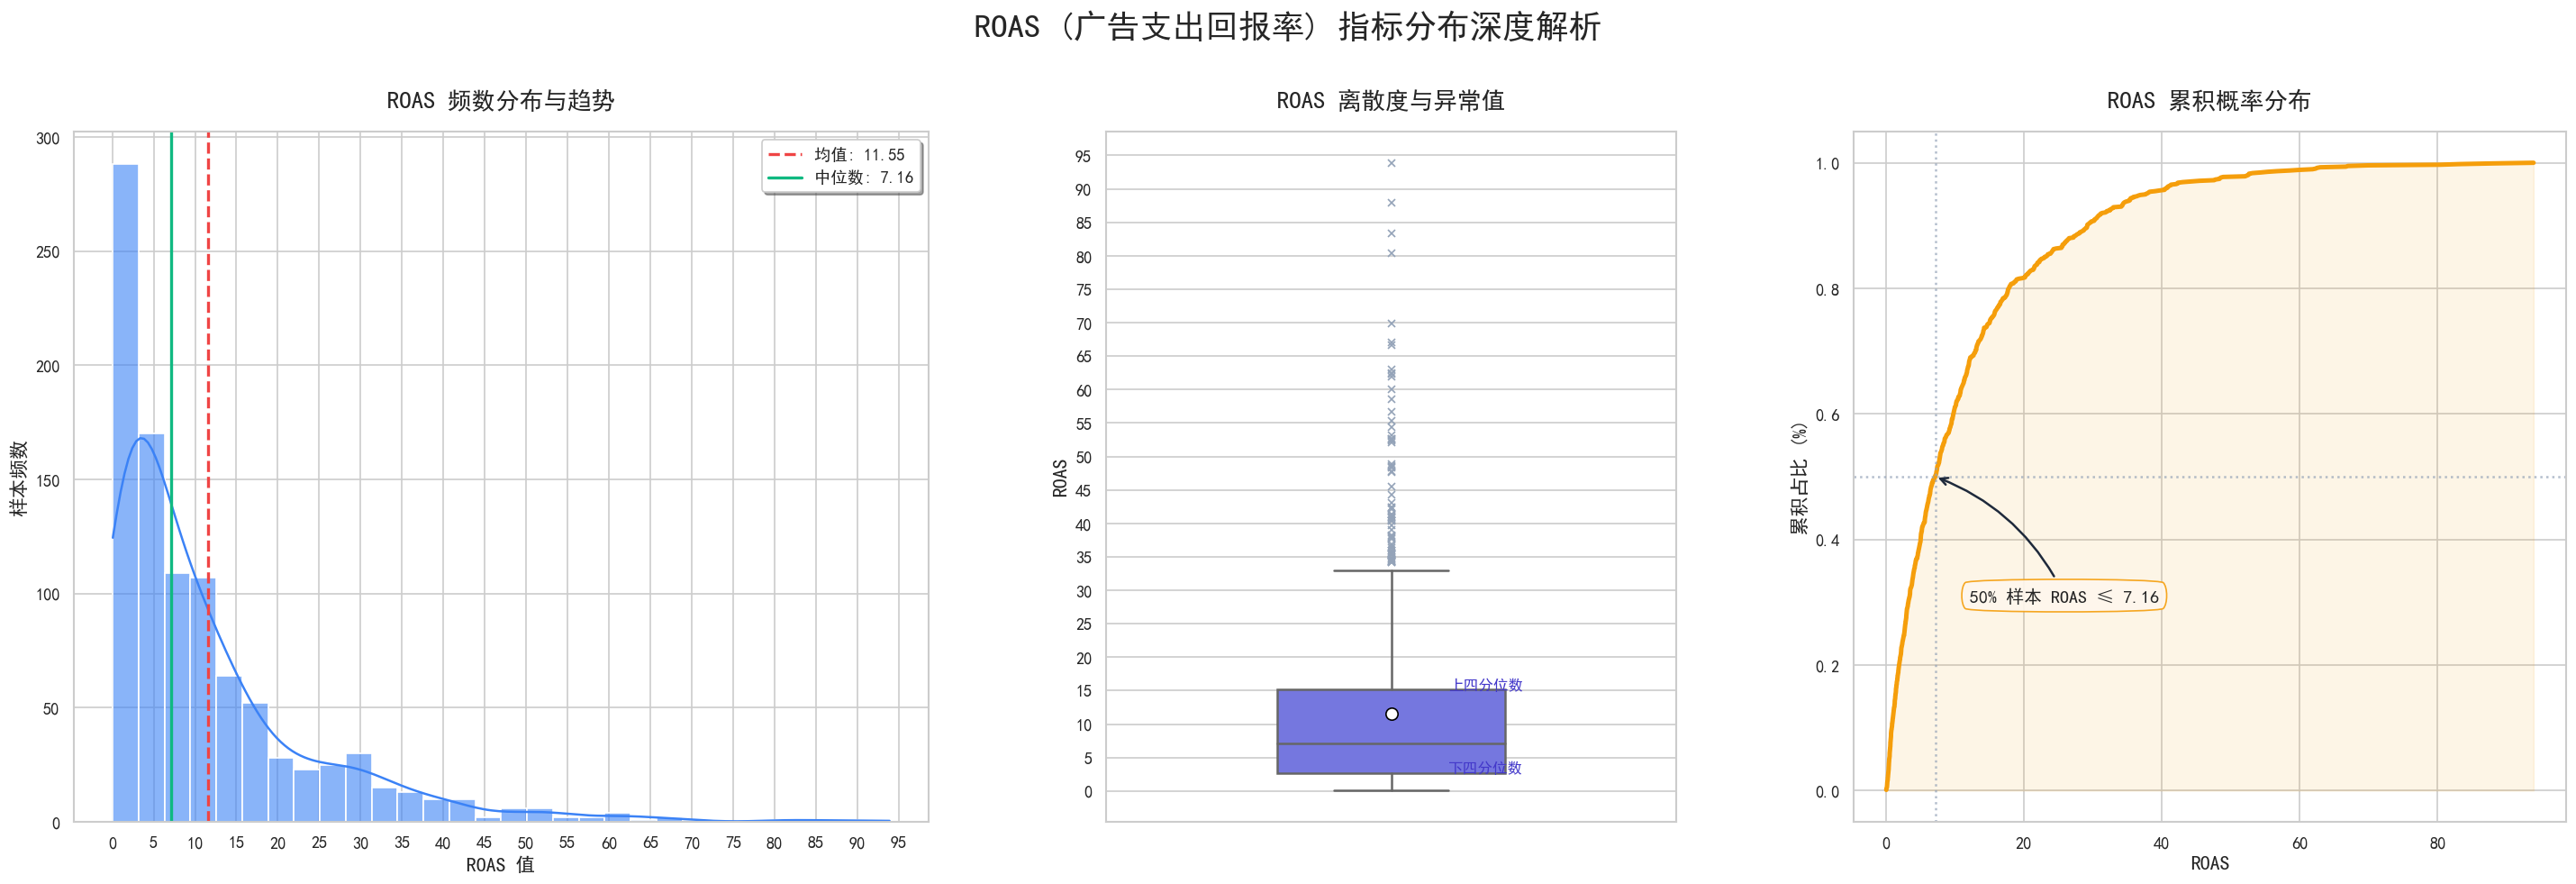

In [91]:
#ROAS分布图表制作
# 设置全局样式 (

sns.set_theme(style="whitegrid", font='SimHei') # 使用白背景网格
plt.rcParams['axes.unicode_minus'] = False     # 解决负号显示
plt.rcParams['figure.dpi'] = 120               # 提高预览分辨率

# 1. 创建画布
fig, axes = plt.subplots(1, 3, figsize=(24, 8), gridspec_kw={'width_ratios': [1.2, 0.8, 1]})
fig.suptitle('ROAS (广告支出回报率) 指标分布深度解析', fontsize=22, fontweight='bold', y=1.02)


# 子图 [0]: 增强型直方图 (带KDE曲线)
sns.histplot(df['ROAS'], bins=30, kde=True, color='#3b82f6', alpha=0.6, ax=axes[0], edgecolor='white')
axes[0].axvline(df['ROAS'].mean(), color='#ef4444', linestyle='--', linewidth=2, 
                label=f'均值: {df["ROAS"].mean():.2f}')
axes[0].axvline(df['ROAS'].median(), color='#10b981', linestyle='-', linewidth=2, 
                label=f'中位数: {df["ROAS"].median():.2f}')

axes[0].set_title('ROAS 频数分布与趋势', fontsize=16, fontweight='bold', pad=15)
axes[0].set_xlabel('ROAS 值', fontsize=13)
axes[0].set_ylabel('样本频数', fontsize=13)
axes[0].xaxis.set_major_locator(MultipleLocator(5))
axes[0].legend(frameon=True, shadow=True)


# 子图 [1]: 箱线图 (
sns.boxplot(y=df['ROAS'], ax=axes[1], color='#6366f1', width=0.4, 
            showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black", "markersize":"8"},
            flierprops={"marker": "x", "markersize": 5, "markeredgecolor": "#94a3b8"})

axes[1].set_title('ROAS 离散度与异常值', fontsize=16, fontweight='bold', pad=15)
axes[1].set_ylabel('ROAS', fontsize=13)
axes[1].yaxis.set_major_locator(MultipleLocator(5))
# 添加背景注释
axes[1].text(0.1, df['ROAS'].quantile(0.75), '上四分位数', color='#4338ca', fontsize=10)
axes[1].text(0.1, df['ROAS'].quantile(0.25), '下四分位数', color='#4338ca', fontsize=10)


# 子图 [2]: 累积分布函数 (CDF)
median_roas = df['ROAS'].median()
sorted_roas = np.sort(df['ROAS'])
cumulative = np.arange(1, len(sorted_roas)+1) / len(sorted_roas)

axes[2].plot(sorted_roas, cumulative, color='#f59e0b', linewidth=3, label='CDF 曲线')
axes[2].fill_between(sorted_roas, cumulative, color='#f59e0b', alpha=0.1) # 添加填充感

axes[2].set_title('ROAS 累积概率分布', fontsize=16, fontweight='bold', pad=15)
axes[2].set_xlabel('ROAS', fontsize=13)
axes[2].set_ylabel('累积占比 (%)', fontsize=13)

# 标注中位数
axes[2].axhline(0.5, color='#94a3b8', linestyle=':', alpha=0.7)
axes[2].axvline(median_roas, color='#94a3b8', linestyle=':', alpha=0.7)

axes[2].annotate(f'50% 样本 ROAS ≤ {median_roas:.2f}',
            xy=(median_roas, 0.50), 
            xytext=(median_roas + 5, 0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2", color='#1e293b', lw=1.5),
            fontsize=12, 
            fontweight='bold',
            bbox=dict(boxstyle="round4,pad=0.5", fc="#fff7ed", ec="#f59e0b", alpha=0.9))


# 整体微调
plt.tight_layout()
plt.subplots_adjust(top=0.88, wspace=0.25) # 留出顶部标题空间，增加列间距

# 输出统计摘要 
print("\n" + "═"*40)
print(f"{'ROAS 指标关键统计量':^36}")
print("═"*40)
stats = df['ROAS'].describe()
for label, val in stats.items():
    print(f" • {label:10}: {val:>10.2f}")
print("═"*40)

plt.show()

**ROAS —— 典型右偏分布，高值由少数活动拉动**
ROAS 整体呈明显右偏分布：

中位数 7.16，但 平均数 11.55（被少数高 ROAS 活动抬高）；

75% 分位数仅 15.16，而最大可达 93.9。

表明绝大多数广告活动的 ROAS 集中在低至中等水平，
而“爆款活动”占比较少，却贡献了高收益。

### CVR/CTR/CPC/RPC分布

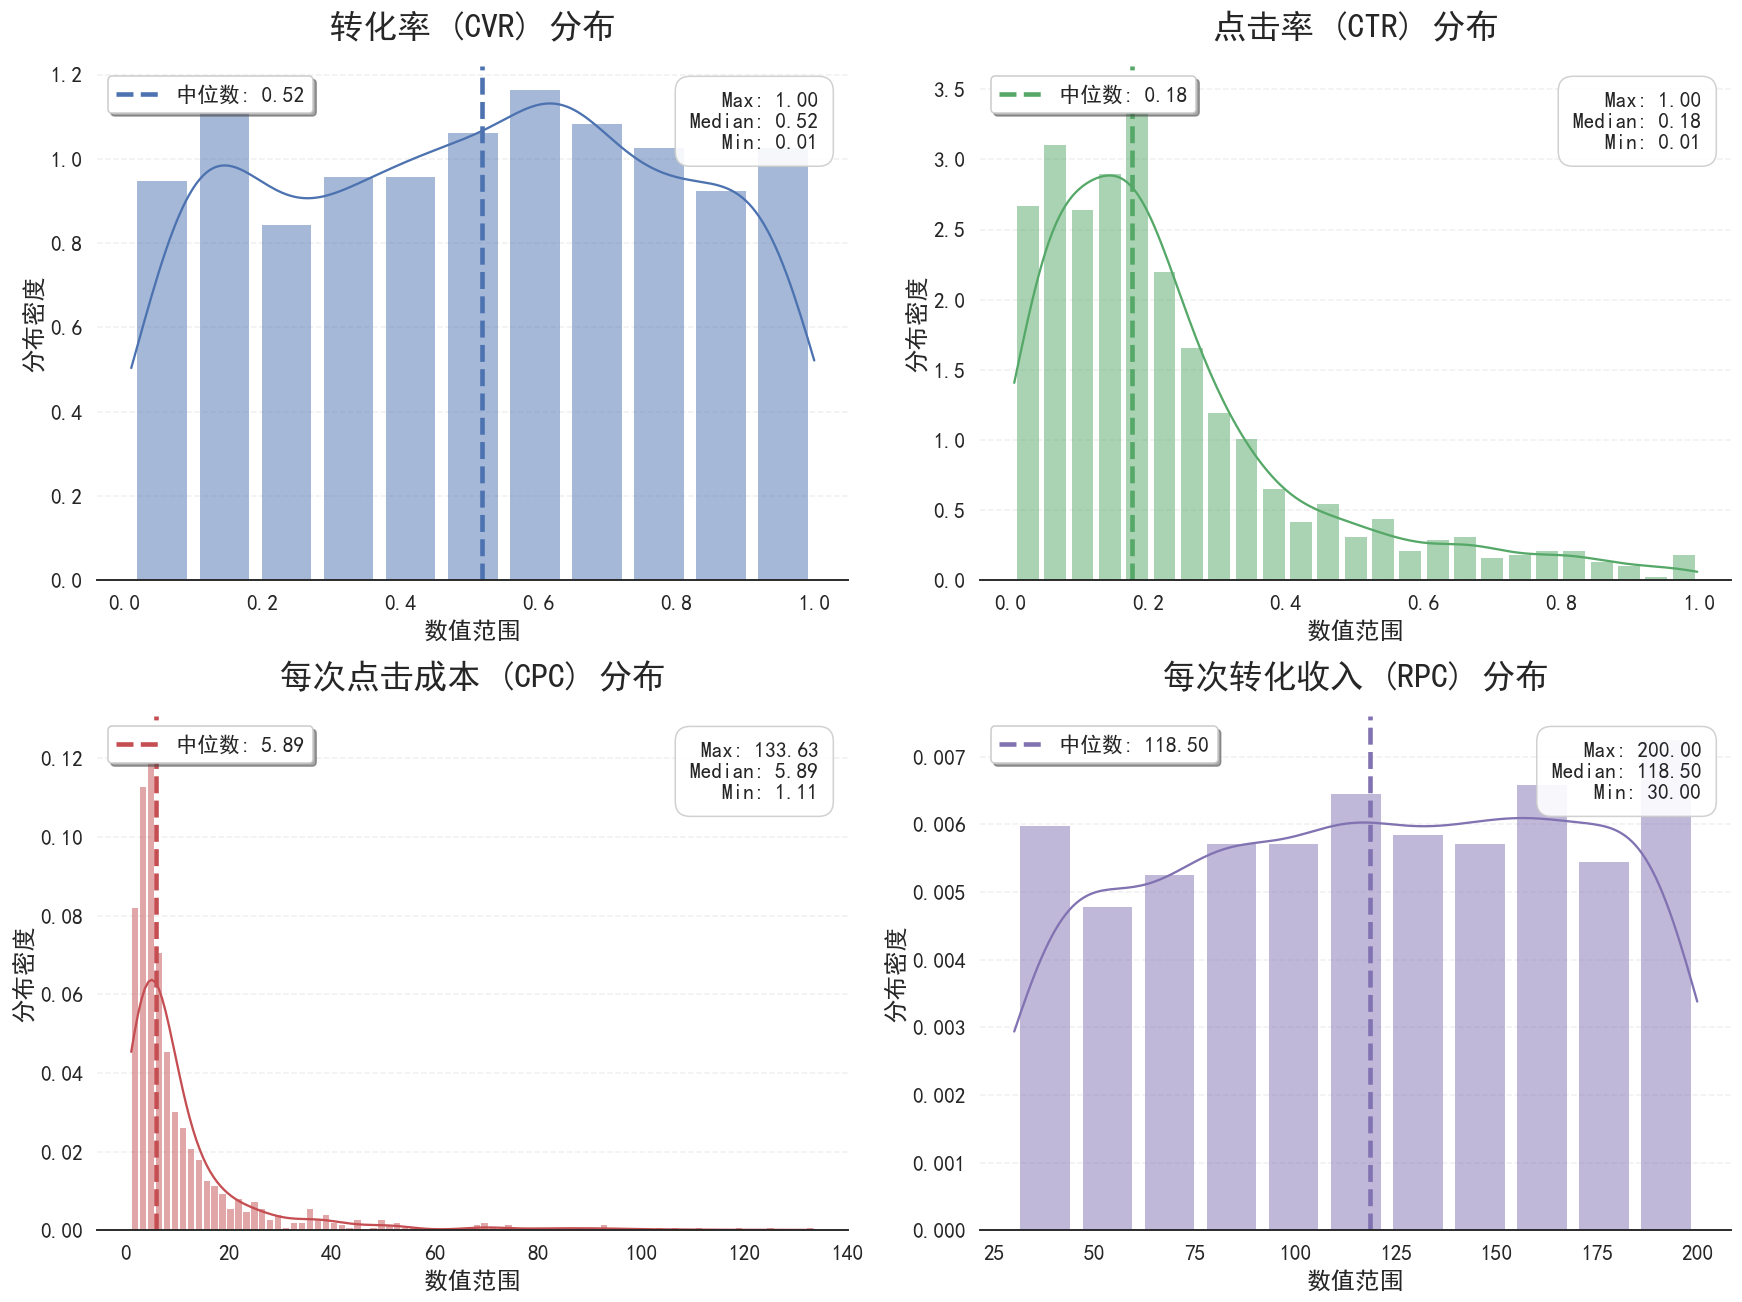

In [26]:
#CVR/CTR/CPC/RPC分布直方图制作
# 1. 全局样式设置
sns.set_theme(style="white") 
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

metrics = {
    'CVR': '转化率 (CVR)',
    'CTR': '点击率 (CTR)',
    'CPC': '每次点击成本 (CPC)',
    'RPC': '每次转化收入 (RPC)'
}
colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2"]


# 2×2 组合图画布
fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=110)
axes = axes.flatten()

for idx, (col, col_name) in enumerate(metrics.items()):
    ax = axes[idx]

    # 分布图
    sns.histplot(
        df[col],
        kde=True,
        color=colors[idx],
        stat="density",
        alpha=0.5,
        linewidth=0,
        fill=True,
        shrink=0.8,
        ax=ax
    )

    # 统计量
    median_val = df[col].median()
    ax.axvline(
        median_val,
        color=colors[idx],
        linestyle='--',
        linewidth=3,
        label=f'中位数: {median_val:.2f}'
    )

    # 标题
    ax.set_title(f'{col_name} 分布', fontsize=22, fontweight='bold', pad=18)

    # 坐标轴 label
    ax.set_xlabel('数值范围', fontsize=16)
    ax.set_ylabel('分布密度', fontsize=16)

    # 刻度字体加大
    ax.tick_params(axis='both', which='major', labelsize=14)

    # 右上角统计框
    stats_text = (
        f"Max: {df[col].max():.2f}\n"
        f"Median: {median_val:.2f}\n"
        f"Min: {df[col].min():.2f}"
    )
    ax.text(
        0.96, 0.95, stats_text,
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment='top',
        horizontalalignment='right',
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.7', 
                  facecolor='white', alpha=0.9, edgecolor='#CCCCCC')
    )

    # 图例
    ax.legend(
        loc='upper left',
        fontsize=14,
        frameon=True,
        shadow=True
    )

    # 样式优化
    sns.despine(ax=ax, left=True)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

# 布局优化
plt.tight_layout()
plt.show()


主要观察：

**价值端（CVR & RPC）——分布均衡、波动可控**

CVR（中位数约 0.52）与 RPC（中位数约 118）整体分布均衡，无明显极端点；

说明业务的转化链路较稳定，收益能力呈现“多路径、多类型广告都能贡献价值”的结构。

**成本端（CTR & CPC）——右偏明显、存在长尾**

CTR、CPC 均呈典型右偏分布（Positive Skew）；

大部分流量集中在低 CPC 区间（中位数约 5.9），少量高竞争位点构成长尾；

高 CPC 长尾需重点监控，因其可能显著拉低整体 ROI。


## 3.分类变量与ROAS

### 3.1分类变量分布与ROAS概览

对五个主要分类变量（平台、内容类型、性别、年龄、地域）的分布与 ROAS 中位数进行了单维度评估。

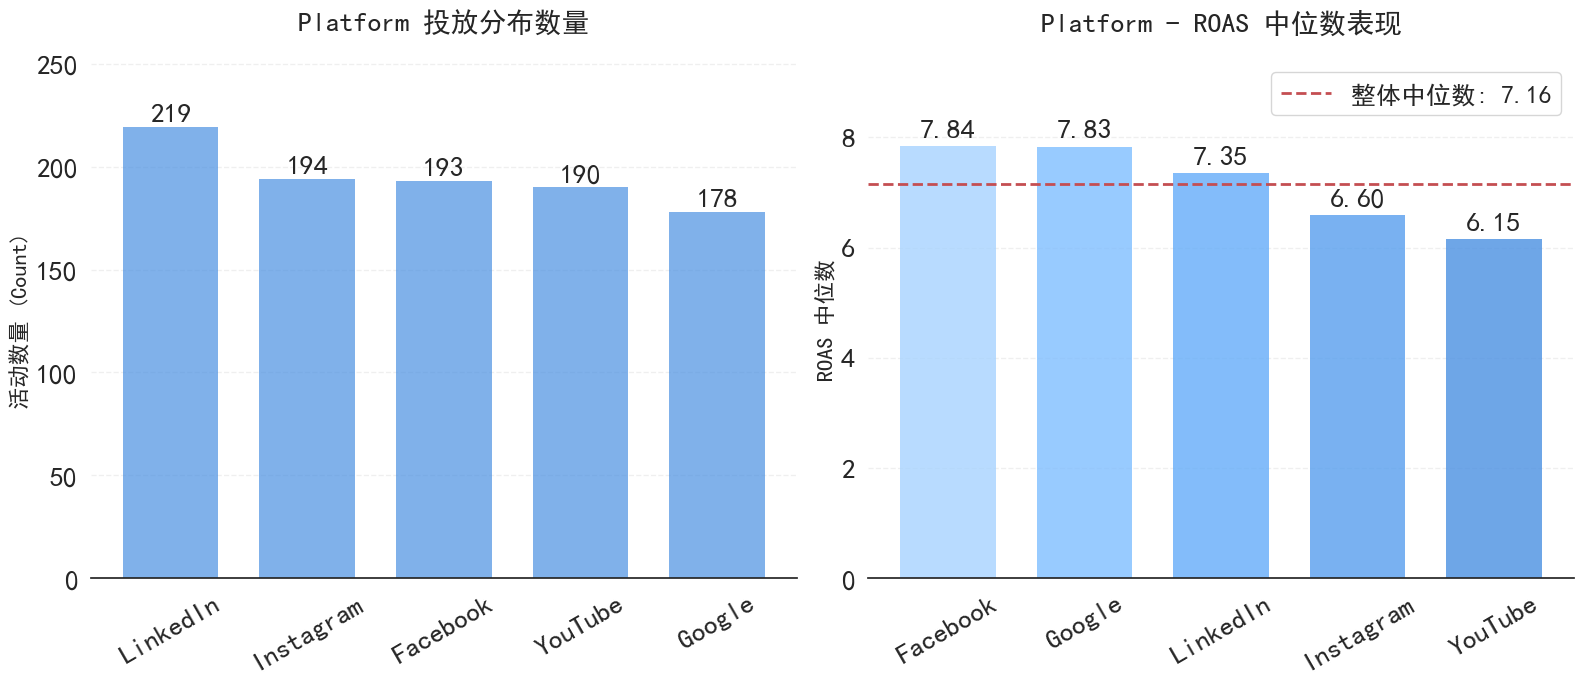

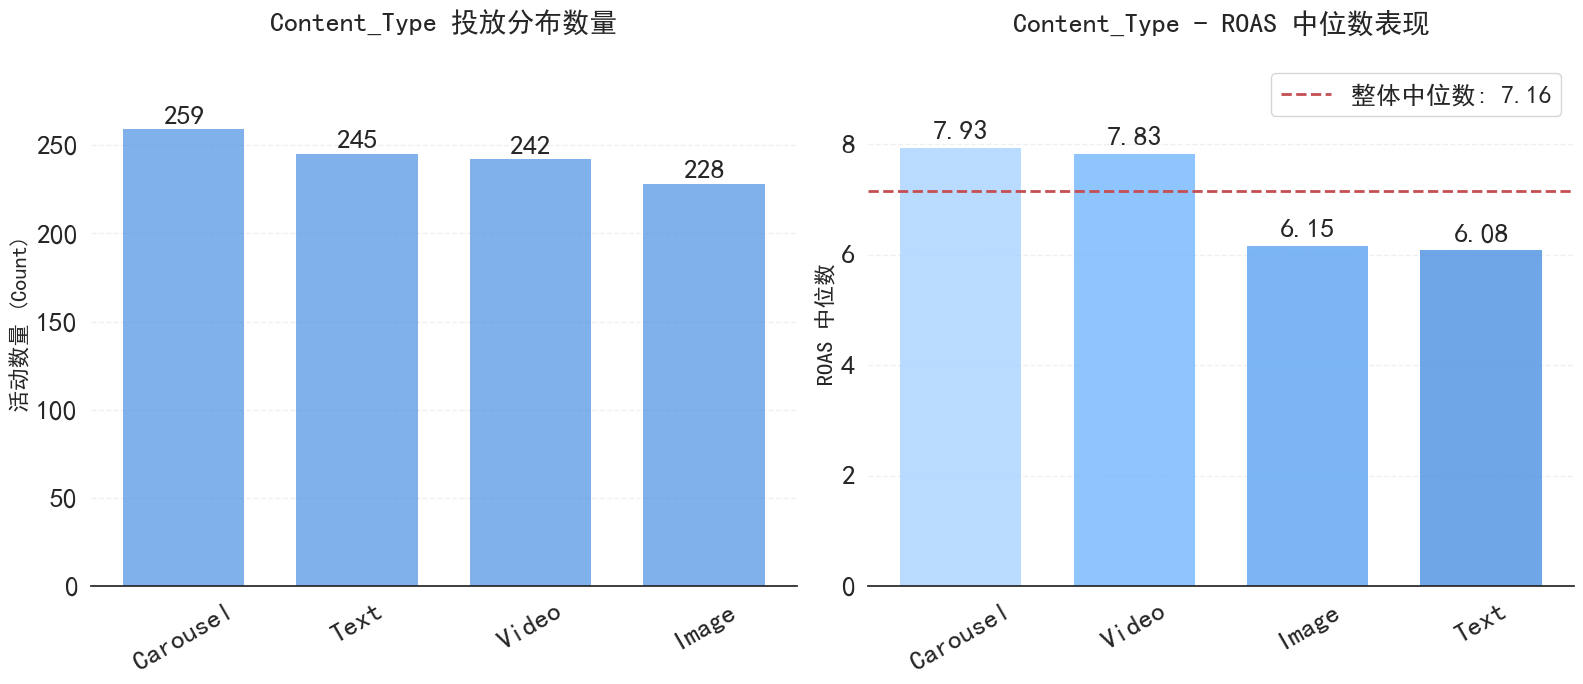

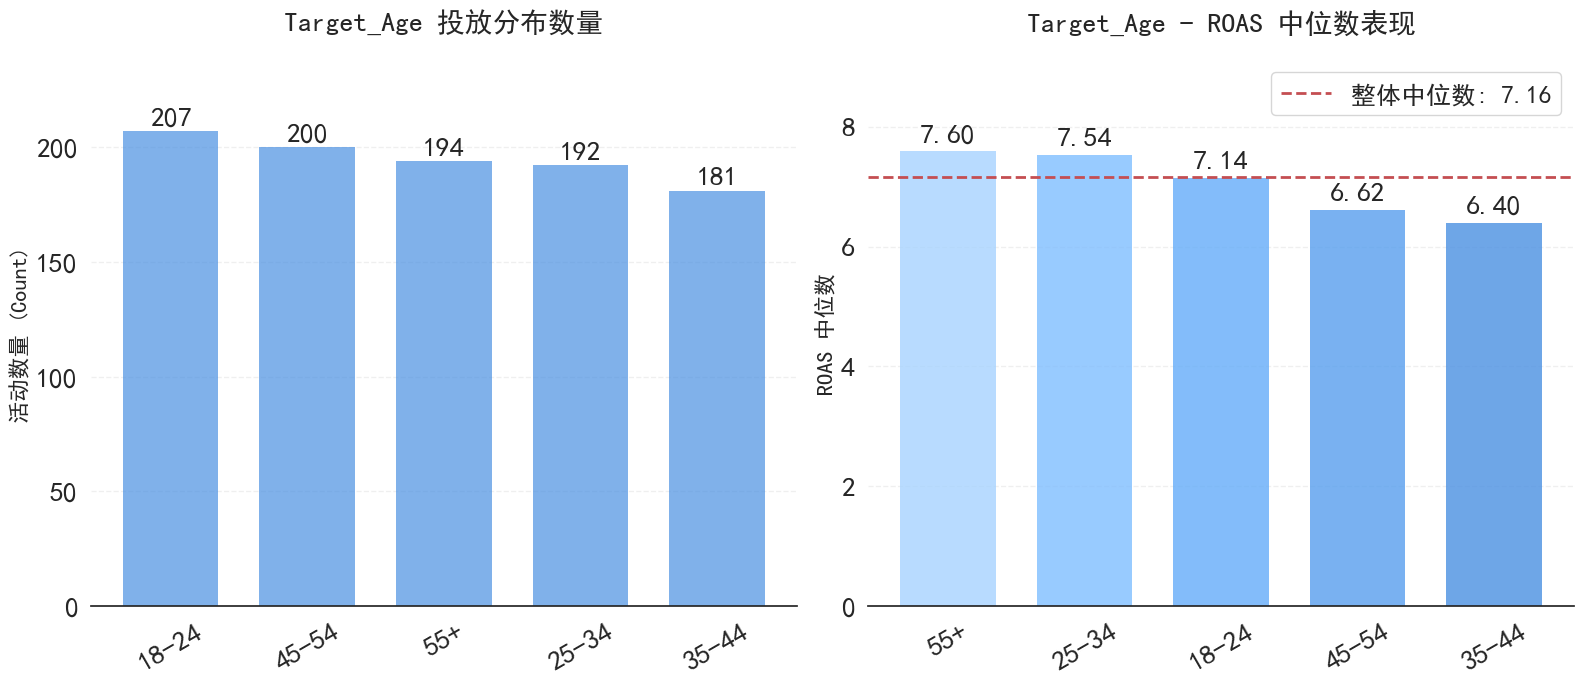

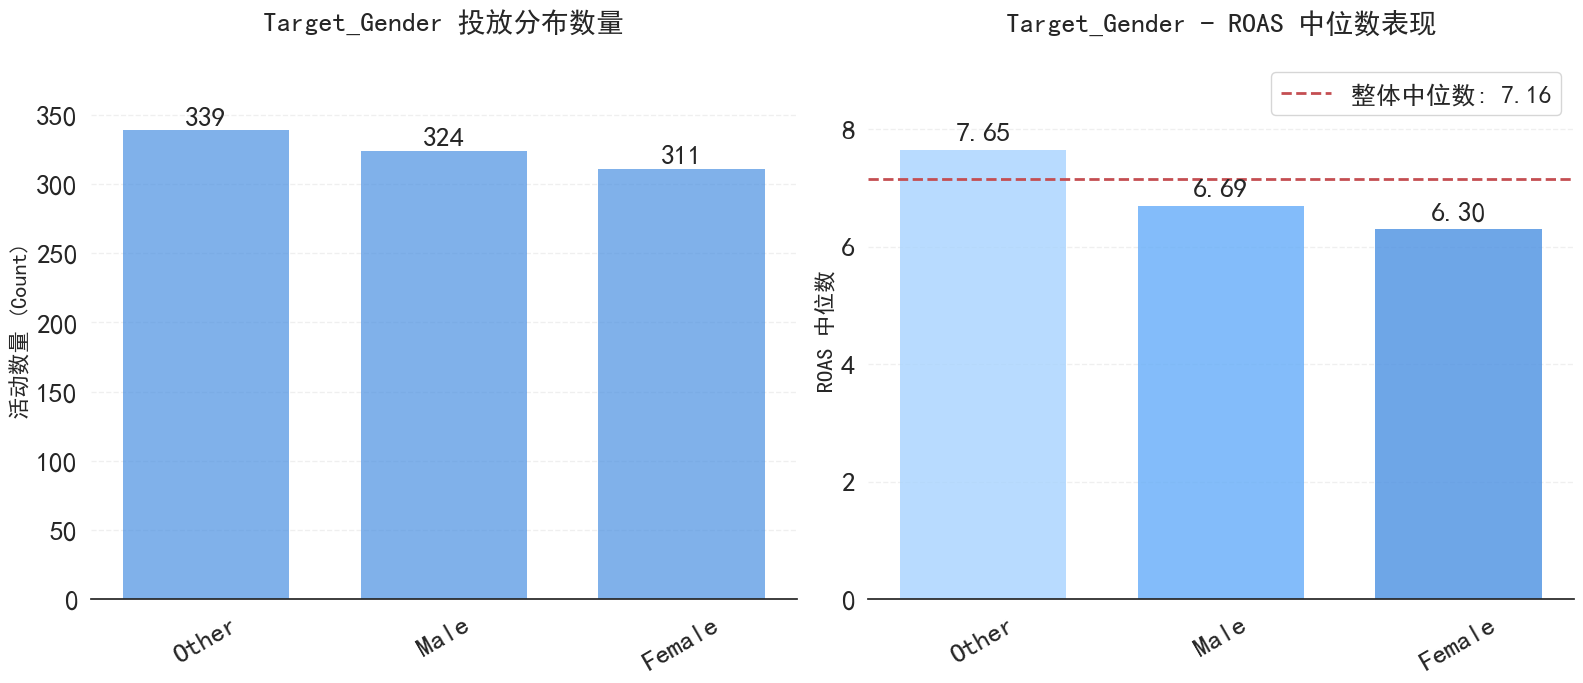

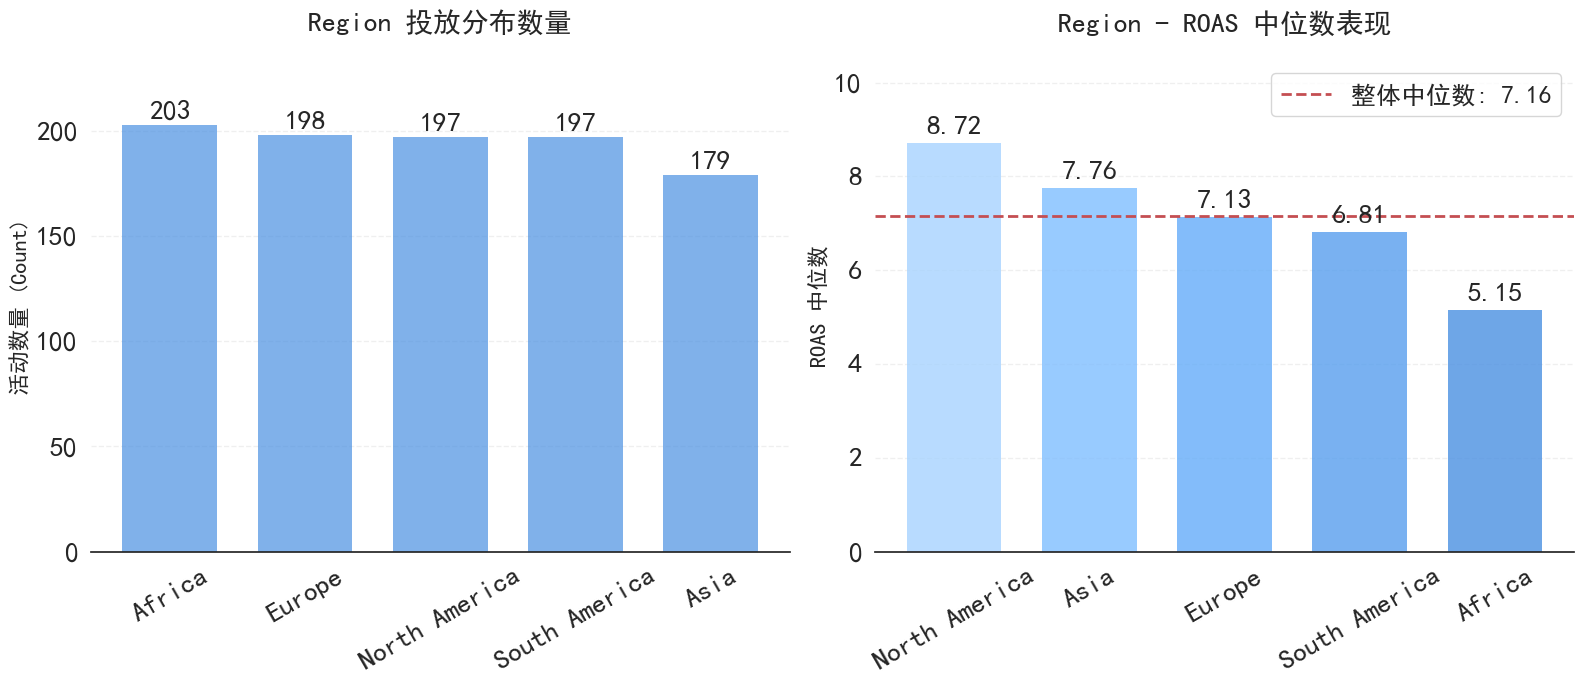

In [74]:
#样本量分布及ROAS表现图
# 1. 基础样式设置
sns.set_theme(style="white")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

categorical_vars = ['Platform', 'Content_Type', 'Target_Age', 'Target_Gender', 'Region']
# 使用之前代码中的商务蓝色
primary_color = "#4A90E2"

# 2. 循环生成独立图片（每组变量一张 1x2 的图）
for var in categorical_vars:
    # 创建 1 行 2 列的画布
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), dpi=100)
    
    # --- 左图：数量分布 (Distribution) ---
    value_counts = df[var].value_counts()
    # 增加间隙 shrink=0.8
    bars1 = ax1.bar(value_counts.index, value_counts.values, 
                    color=primary_color, alpha=0.7, edgecolor='none', width=0.7)
    
    ax1.set_title(f'{var} 投放分布数量', fontsize=20, fontweight='bold', pad=20)
    ax1.set_ylabel('活动数量 (Count)', fontsize=16)
    ax1.tick_params(axis='both', labelsize=20)
    plt.setp(ax1.get_xticklabels(), rotation=30) # 旋转 X 轴标签防止重叠
    
    # 动态设置 Y 轴范围，留出顶部空间给数字
    ax1.set_ylim(0, value_counts.values.max() * 1.15)
    
    # 在柱子上显示数量
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{int(height)}', ha='center', va='bottom', fontsize=20, fontweight='bold')

    # --- 右图：ROAS 中位数表现 (Performance) ---
    roas_by_category = df.groupby(var)['ROAS'].median().sort_values(ascending=False)
    
    # 使用渐变色
    from matplotlib.colors import LinearSegmentedColormap

    custom_blues = LinearSegmentedColormap.from_list(
        "custom_blues",
        ["#CFE8FF", "#6BB3FF", "#4A90E2"]  # 浅 → 中 → 深
    )

    colors = custom_blues(np.linspace(0.2, 1, len(roas_by_category)))

    
    bars2 = ax2.bar(roas_by_category.index, roas_by_category.values, 
                    color=colors, alpha=0.8, edgecolor='none', width=0.7)
    
    ax2.set_title(f'{var} - ROAS 中位数表现', fontsize=20, fontweight='bold', pad=20)
    ax2.set_ylabel('ROAS 中位数', fontsize=16)
    ax2.tick_params(axis='both', labelsize=20)
    plt.setp(ax2.get_xticklabels(), rotation=30)
    
    # 在柱子上显示数值
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{height:.2f}', ha='center', va='bottom', fontsize=20, fontweight='bold')

    # 添加整体中位数参考线
    overall_median = df['ROAS'].median()
    ax2.axhline(y=overall_median, color='#C44E52', linestyle='--', linewidth=2, 
                label=f'整体中位数: {overall_median:.2f}')
    
    # 动态设置 Y 轴范围
    ax2.set_ylim(0, roas_by_category.values.max() * 1.2)
    
    # 美化共性设置
    for ax in [ax1, ax2]:
        sns.despine(ax=ax, left=True) # 去除边框
        ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    ax2.legend(fontsize=18, loc='upper right', frameon=True)
    
    plt.tight_layout()
    plt.show()



主要观察：

各分类变量的样本分布较为均匀。

不同类别之间的 ROAS 中位数存在差异但并不显著。

### 3.2分类变量对 ROAS 回报与波动的四象限

为了评估不同分类变量对 ROAS 表现的影响，我对每个分类变量绘制了四象限图。
- 纵轴：ROAS 中位数，反映回报水平
- 横轴：ROAS 标准差，反映回报波动或风险
- 点的颜色：不同分类变量类别

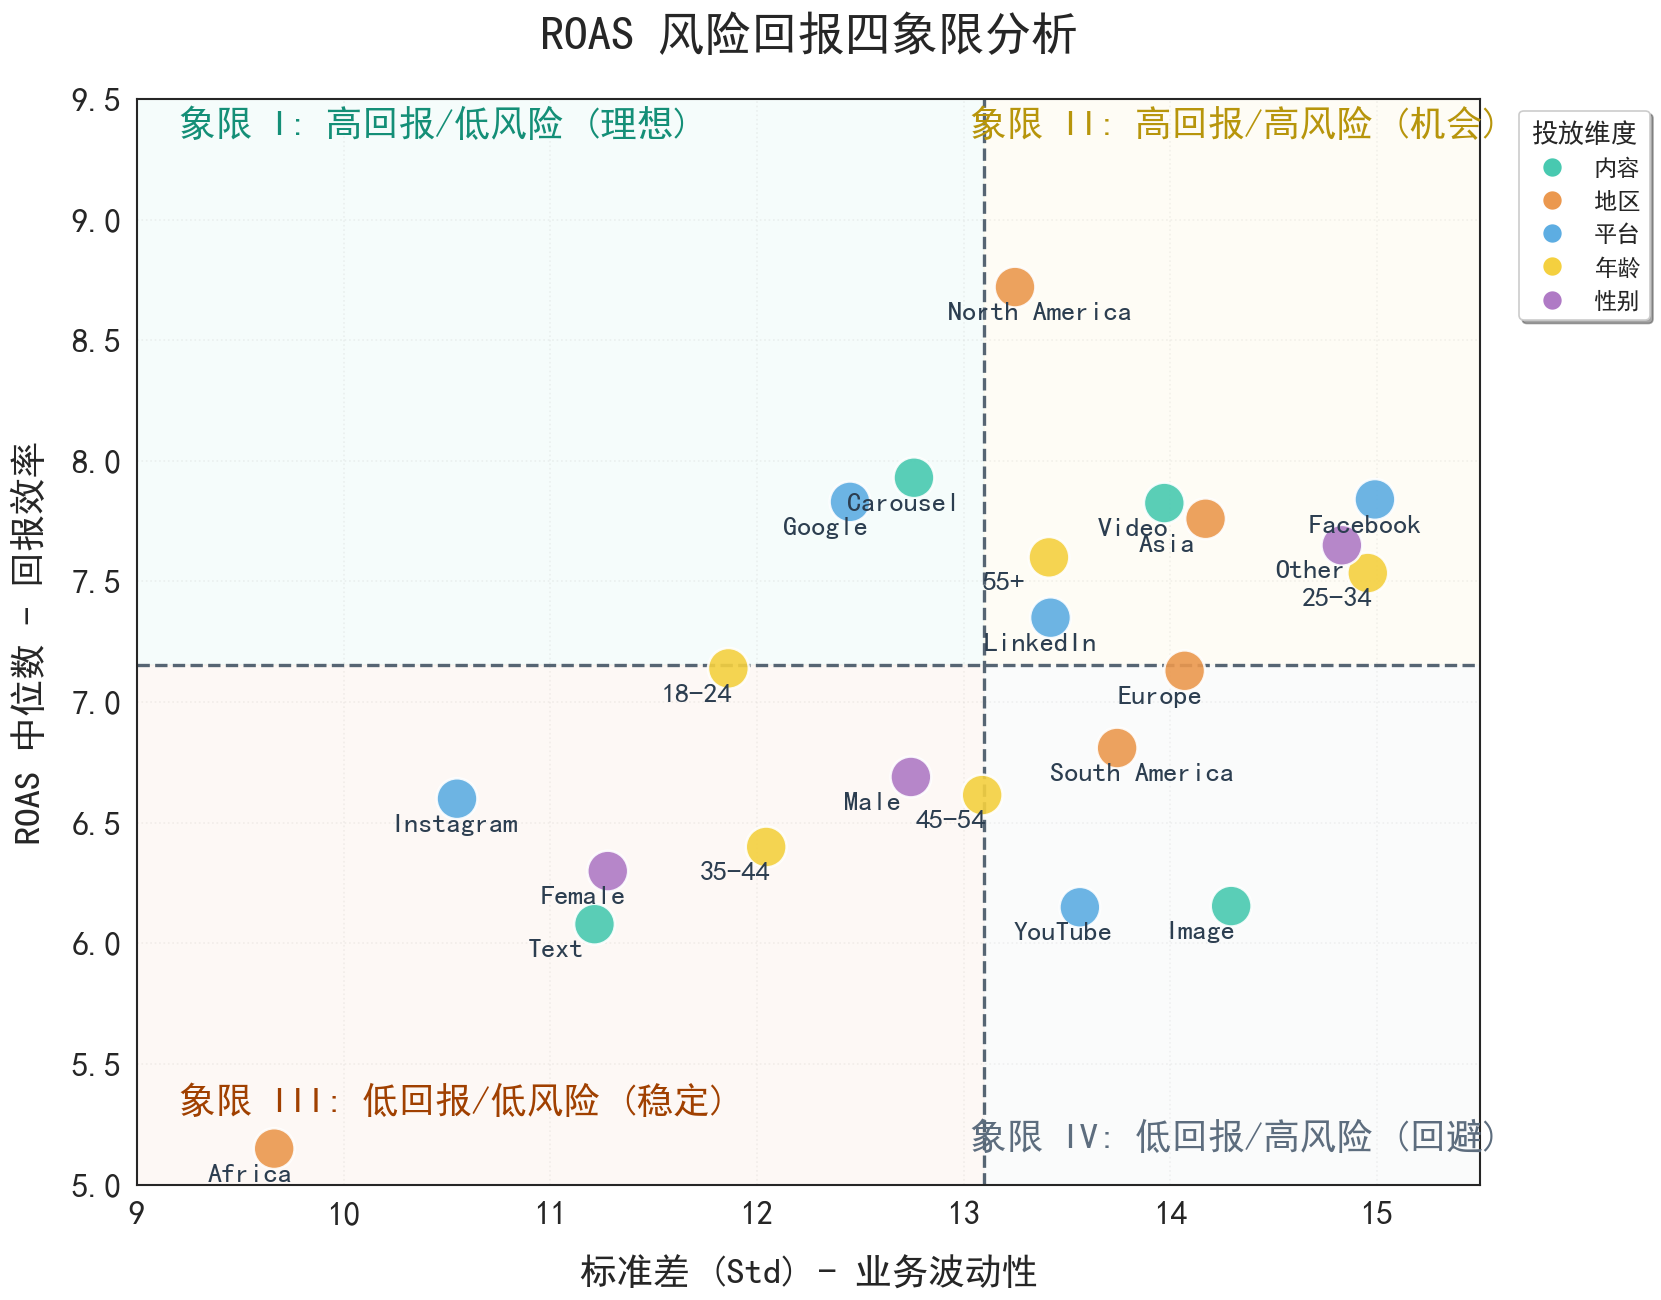

In [79]:
#四象限图
# 维度列表 + 每个维度的颜色映射
dimension_config = {
    'Platform': {'category': '平台', 'color': '#5DADE2'},
    'Content_Type': {'category': '内容', 'color': '#48C9B0'},
    'Target_Age': {'category': '年龄', 'color': '#F4D03F'},
    'Target_Gender': {'category': '性别', 'color': '#AF7AC5'},
    'Region': {'category': '地区', 'color': '#EB984E'}
}


data_points = []

for col, cfg in dimension_config.items():
    groups = df.groupby(col)['ROAS']

    for label, group in groups:
        data_points.append({
            'category': cfg['category'],
            'label': label,
            'median': group.median(),
            'std': group.std(),
            'color': cfg['color']
        })

# 分割线阈值
MEDIAN_ROAS_SPLIT = df['ROAS'].median()
STD_SPLIT = df['ROAS'].std()

# 提取点数据
x_values = [p['std'] for p in data_points]
y_values = [p['median'] for p in data_points]
colors = [p['color'] for p in data_points]
labels = [p['label'] for p in data_points]

plt.figure(figsize=(14, 11))
ax = plt.gca()

# 绘制背景象限色块
ax.fill_between([9, STD_SPLIT], MEDIAN_ROAS_SPLIT, 9.5, color='#E8F8F5', alpha=0.4)  # 象限 I: 理想
ax.fill_between([STD_SPLIT, 15.5], MEDIAN_ROAS_SPLIT, 9.5, color='#FEF9E7', alpha=0.4) # 象限 II: 机会
ax.fill_between([9, STD_SPLIT], 5, MEDIAN_ROAS_SPLIT, color='#FBEEE6', alpha=0.4)     # 象限 III: 陷阱
ax.fill_between([STD_SPLIT, 15.5], 5, MEDIAN_ROAS_SPLIT, color='#F4F6F7', alpha=0.4)  # 象限 IV: 回避

# 绘制散点
scatter = ax.scatter(x_values, y_values, c=colors, s=600, alpha=0.9, edgecolors='white', linewidth=1.5, zorder=5)


# 绘制四象限分割线
ax.axhline(MEDIAN_ROAS_SPLIT, color='#566573', linestyle='--', linewidth=2, zorder=2)
ax.axvline(STD_SPLIT, color='#566573', linestyle='--', linewidth=2, zorder=2)


# 象限标签
label_style = {'fontsize':22, 'fontweight': 'bold'}
ax.text(9.2, 9.35, '象限 I: 高回报/低风险 (理想)', ha='left', color='#148F77', **label_style)
ax.text(15.6, 9.35, '象限 II: 高回报/高风险 (机会)', ha='right', color='#B7950B', **label_style)
ax.text(9.2, 5.3, '象限 III: 低回报/低风险 (稳定)', ha='left', color='#A04000', **label_style)
ax.text(15.6, 5.15, '象限 IV: 低回报/高风险 (回避)', ha='right', color='#5D6D7E', **label_style)

# 数据点标注
for i, (x, y) in enumerate(zip(x_values, y_values)):
    ax.annotate(labels[i], (x, y), xytext=(-40,-20), textcoords='offset points', 
                fontsize=17, fontweight='bold', color='#2C3E50', zorder=6)


#  标题和轴标签
ax.set_title('ROAS 风险回报四象限分析', fontsize=28, fontweight='bold', pad=30)
ax.set_xlabel('标准差 (Std) - 业务波动性', fontsize=22, labelpad=15)
ax.set_ylabel('ROAS 中位数 - 回报效率', fontsize=22, labelpad=15)
ax.tick_params(labelsize=20)


#  图例
unique_categories = sorted(list(set(p['category'] for p in data_points)))
category_colors = {p['category']: p['color'] for p in data_points}
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=cat, 
                   markerfacecolor=category_colors[cat], markersize=12) for cat in unique_categories]
ax.legend(handles=legend_elements, title="投放维度", title_fontsize=16, fontsize=14, 
          bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True, shadow=True)


# 网格、坐标轴范围
ax.grid(True, linestyle=':', alpha=0.4)
ax.set_xlim(9, 15.5)
ax.set_ylim(5, 9.5)



plt.tight_layout()
plt.show()


主要观察：
- 高回报往往伴随高风险，回报与风险呈正相关。
- 地区：North America 回报最高且波动适中，Africa回报最低风险最小。
- 平台： Google 高回报低波动，YouTube 回报低且波动大
- 内容类型：Carousel 回报最高且波动较小；
- 年龄： 25-34 和 55+ 回报较高但伴随较高波动；
- 性别：Other 类别回报高但波动也大，Male 和 Female 回报稳定但偏低。

由于本分析仅考虑单因素，四象限图主要用于快速识别潜在高回报或高风险类别，用于决策优化广告组合的参考，而非绝对结论。

## 4.时间变量与ROAS

研究ROAS是否随时间发生趋势或周期性变化。

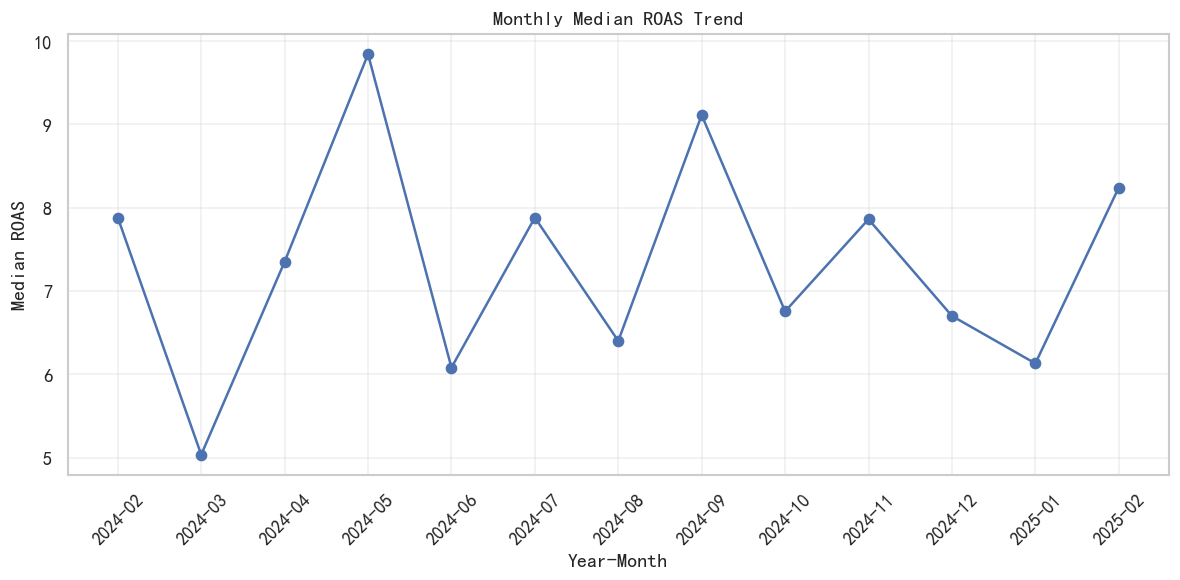

In [93]:
#新建日期相关字段
df['year_month'] = df['Date'].dt.to_period('M')

#统计不同月roas表现
monthly_roas = (
    df.groupby('year_month')['ROAS']
      .median()
      .reset_index()
      .sort_values('year_month')
)
plt.figure(figsize=(10, 5))
plt.plot(
    monthly_roas['year_month'].astype(str),
    monthly_roas['ROAS'],
    
    marker='o'
)

plt.xlabel('Year-Month')
plt.ylabel('Median ROAS')
plt.title('Monthly Median ROAS Trend')

plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

经时间维度检查（ROAS vs Date），业务效率无趋势和周期性，故后续建模和策略分析不将时间作为主要变量。

## 5. 数值变量与ROAS

### 5.1 数值变量相关性矩阵

使用 Pearson 相关系数 **评估各数值变量间的线性关系，尤其是与 Log_ROAS 的线性关系**（对右偏指标进行了 log 转换）。

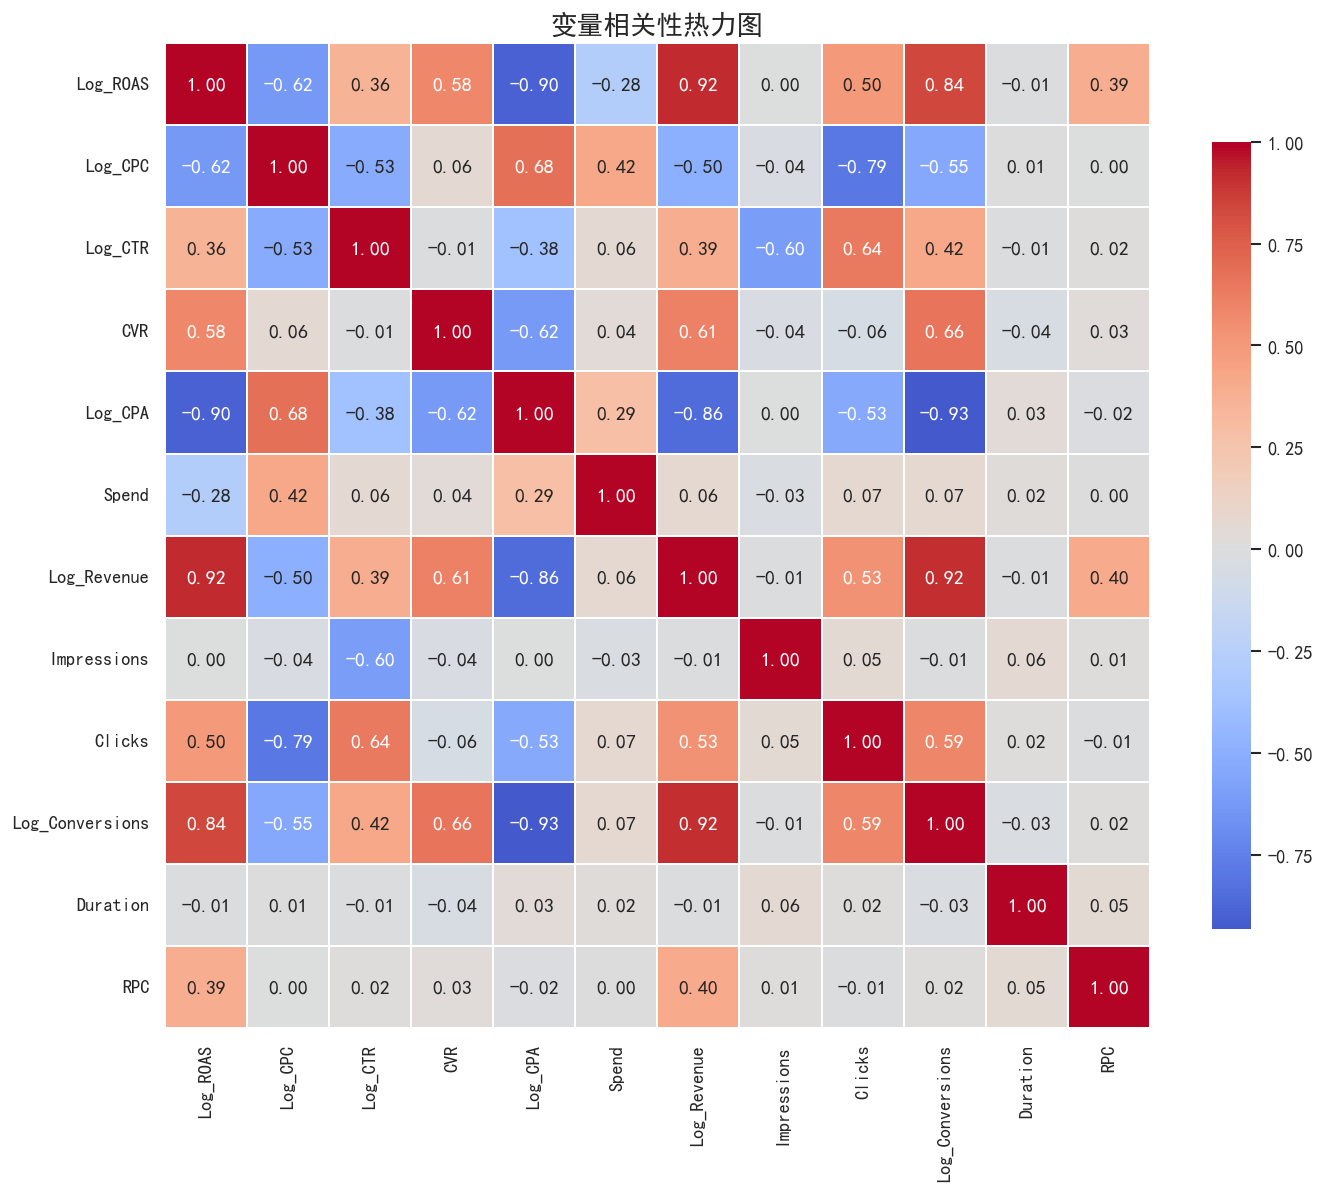

各变量与Log_ROAS的相关系数
Log_ROAS           1.000000
Log_Revenue        0.920452
Log_Conversions    0.837121
CVR                0.578398
Clicks             0.497529
RPC                0.392875
Log_CTR            0.362363
Impressions        0.000250
Duration          -0.007954
Spend             -0.280600
Log_CPC           -0.623843
Log_CPA           -0.901431
Name: Log_ROAS, dtype: float64


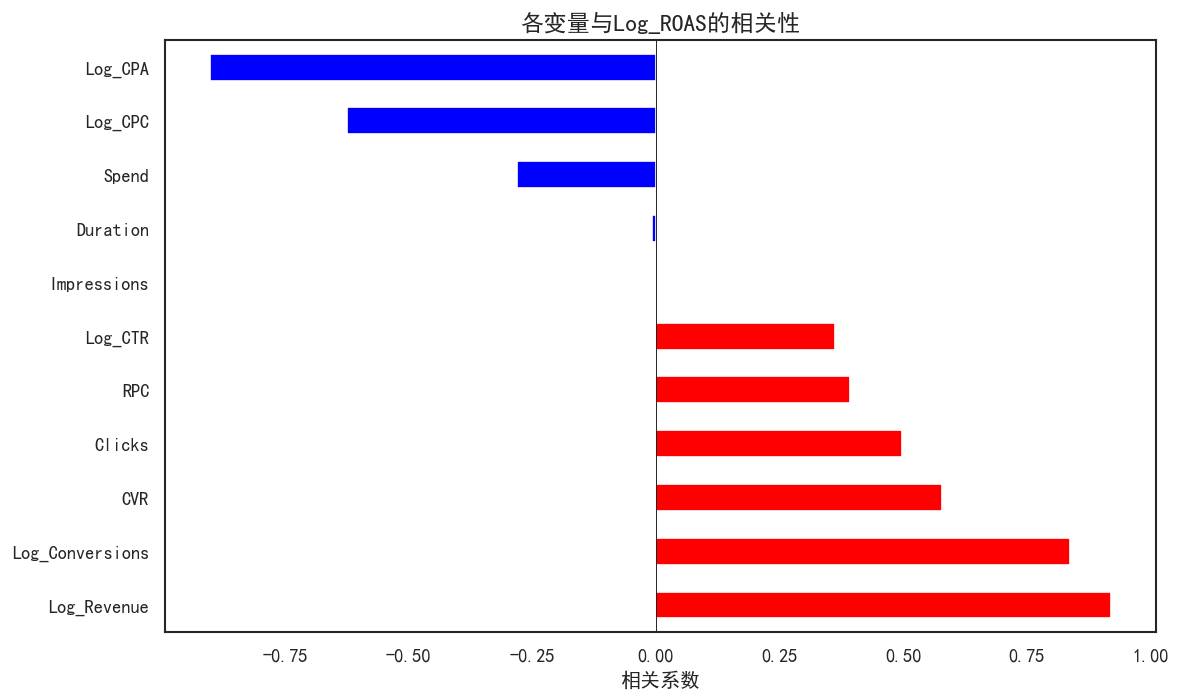

In [34]:
#数值变量相关性矩阵
numeric_vars = ['Log_ROAS', 'Log_CPC', 'Log_CTR', 'CVR', 'Log_CPA', 
                'Spend', 'Log_Revenue', 'Impressions', 'Clicks', 
                'Log_Conversions', 'Duration','RPC']

corr_matrix =df[numeric_vars].corr()

# 热力图
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, 
            cbar_kws={"shrink": 0.8})
plt.title('变量相关性热力图', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 重点看:Log_ROAS和其他变量的相关性
roas_corr = corr_matrix['Log_ROAS'].sort_values(ascending=False)
print("="*80)
print("各变量与Log_ROAS的相关系数")
print("="*80)
print(roas_corr)

# 可视化
plt.figure(figsize=(10, 6))
roas_corr[1:].plot(kind='barh', color=['red' if x > 0 else 'blue' for x in roas_corr[1:]])
plt.title('各变量与Log_ROAS的相关性', fontsize=14, fontweight='bold')
plt.xlabel('相关系数')
plt.axvline(0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()


根据图像可得：

 - 跟roas正相关（相关度从大到小的有）：Log_Revenue,Log_Conversions,CVR,Clicks,RPC,Log_CTR

 - 跟roas负相关（相关度从大到小的有）：Log_CPA,Log_CPC,Spend.

接下来着重研究RPC CVR CPC和ROAS的关系

### 5.2 ROAS与CPC/CVR/CTR/ROAS散点图

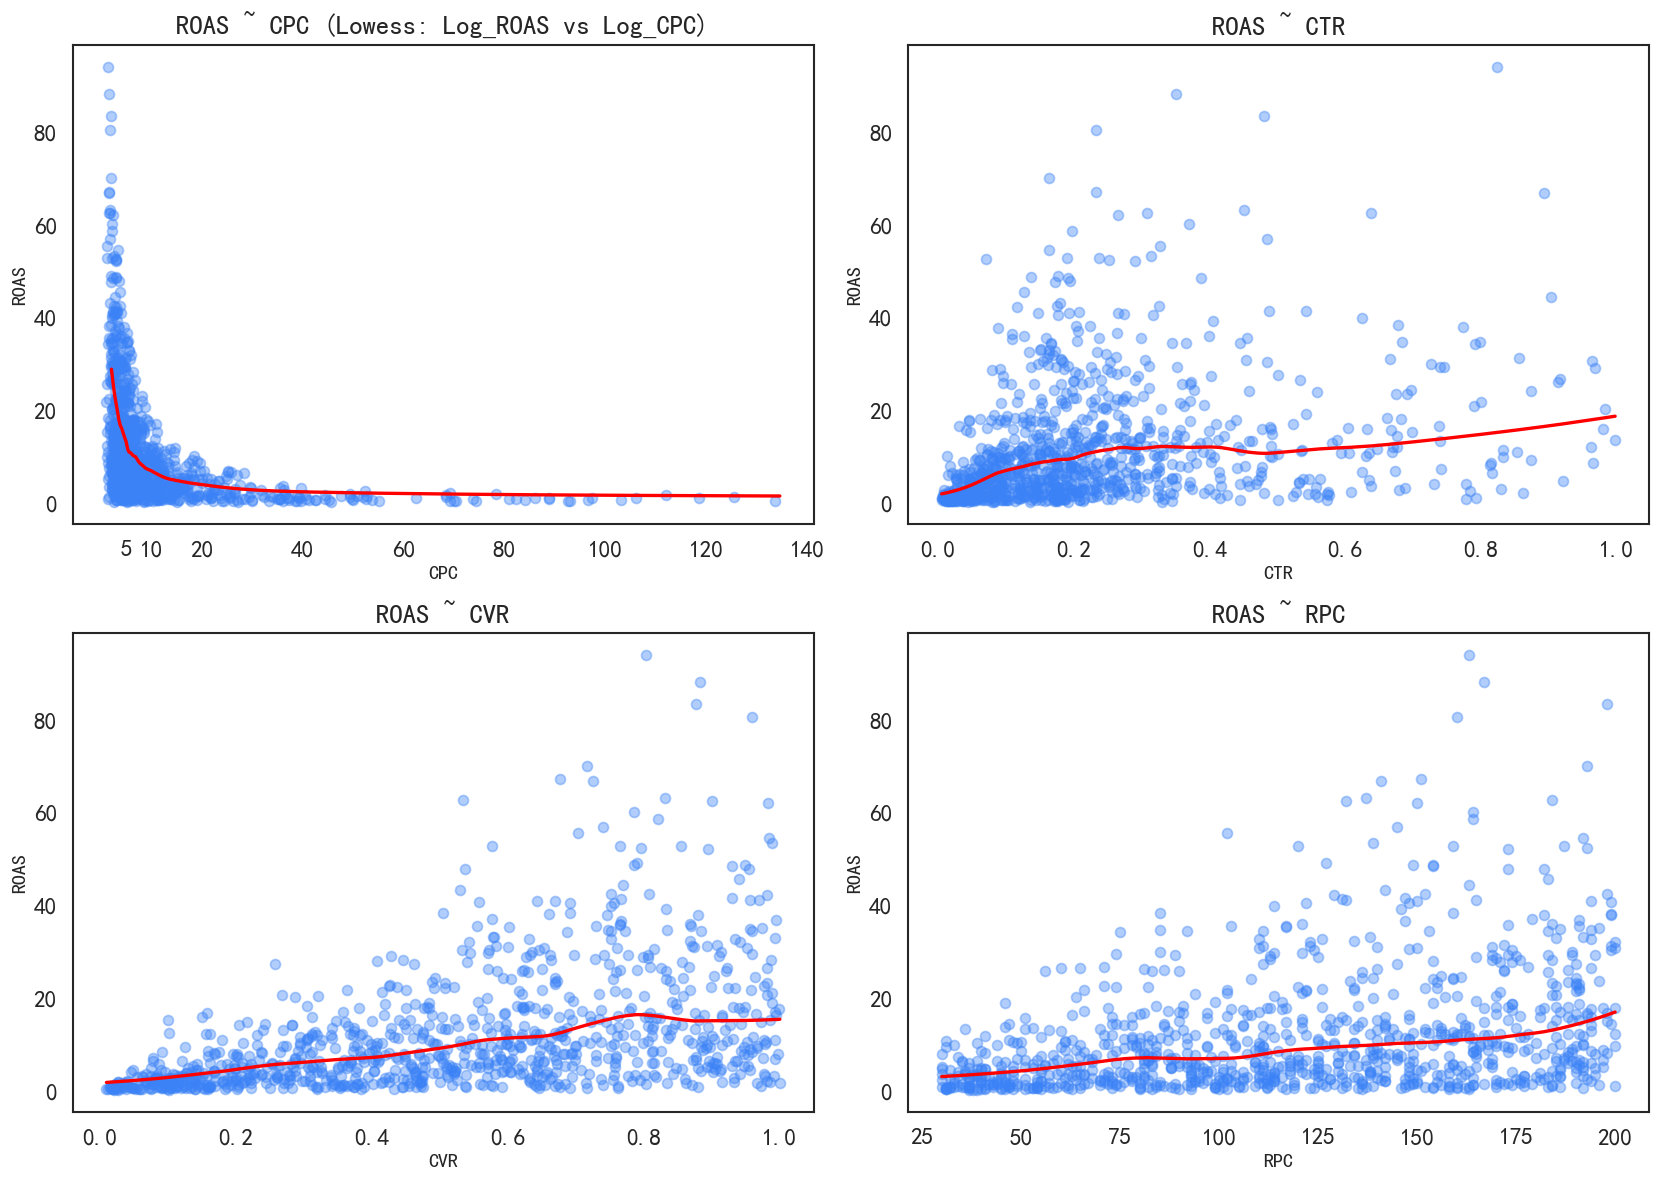

In [38]:
# ROAS 与 CPC / CTR / CVR / RPC 的组合散点 + Lowess 拟合图


import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

def scatter_with_lowess(ax, df, x_raw, x_log=None, y_raw="ROAS", y_log="Log_ROAS", title=None):
    
    # 原始散点
    ax.scatter(df[x_raw], df[y_raw], alpha=0.4, color='#3b82f6')

    # X 用不用 log
    x_for_lowess = df[x_log] if x_log else df[x_raw]
    y_for_lowess = df[y_log]  # y 用 log 版本

    # LOWESS 拟合（使用 log 尺度）
    smooth = lowess(y_for_lowess, x_for_lowess, frac=0.25)

    # x 如果是 log 就 exp 回去
    smooth_x = np.exp(smooth[:, 0]) if x_log else smooth[:, 0]

    # y exp 回原始 ROAS
    smooth_y = np.exp(smooth[:, 1])

    # 拟合曲线
    ax.plot(smooth_x, smooth_y, linewidth=2, color='red')

    # 轴标签 & 标题
    ax.set_xlabel(x_raw)
    ax.set_ylabel(y_raw)
    ax.set_title(title, fontsize=16)
    ax.tick_params(axis='both', labelsize=14)


    # 特殊的 CPC X 轴刻度
    if x_raw == "CPC":
        ax.set_xticks([5, 10, 20, 40, 60, 80, 100, 120, 140])


# ---------------------------------
# 组合图：2 行 × 2 列
# ---------------------------------

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 第 1 图：ROAS ~ CPC（带 log）
scatter_with_lowess(
    axes[0, 0], df,
    x_raw="CPC",
    x_log="Log_CPC",
    title="ROAS ~ CPC (Lowess: Log_ROAS vs Log_CPC)"
)

# 第 2 图：ROAS ~ CTR
scatter_with_lowess(
    axes[0, 1], df,
    x_raw="CTR",
    x_log=None,
    title="ROAS ~ CTR"
)

# 第 3 图：ROAS ~ CVR
scatter_with_lowess(
    axes[1, 0], df,
    x_raw="CVR",
    x_log=None,
    title="ROAS ~ CVR"
)

# 第 4 图：ROAS ~ RPC
scatter_with_lowess(
    axes[1, 1], df,
    x_raw="RPC",
    x_log=None,
    title="ROAS ~ RPC"
)

plt.tight_layout()
plt.show()


主要观察：
- **CPC 影响：** 负相关显著，低价获客是高 ROAS 关键驱动。
- **CVR/RPC 影响：** 稳步正相关，提升转化质量是长期目标。
- **CTR 影响：** 关联度有限，需警惕“高点击、低转化”的流量陷阱。

## 6. 聚焦CPC0-5，高ROAS关键区间挖掘

### 6.1 为什么选择CPC<=5


选择原因：

① 样本量重组：CPC ≤ 5 占整体数据 41.2%，代表性强

② 高 ROAS 活动集中：ROAS > 40 的占比随 CPC 升高快速下降。

③ ROAS 中位数随 CPC 上升明显下降，呈收益衰减趋势。

④ 与本数据集及投放经验一致：CPC ≤ 5 区间覆盖大量样本，且高 ROAS 活动集中，是分析和优化的主力区间。

### 6.2低 CPC 区间下的分类变量表现

对 Platform、Content_Type、Target_Age、Target_Gender、Region 进行 ROAS 分箱分析

In [81]:
#ROAS分箱

# 1️⃣ 筛选 CPC 0-5 区间
low_cpc_df = df[df['CPC'] <= 5].copy()

# 2️⃣ 按 ROAS 实际值分组（可调整区间）
bins = [0,5,10, 20, 40, 60, low_cpc_df['ROAS'].max()]
labels = ['0-5','5-10','10-20', '20-40', '40-60', '60+']
low_cpc_df['ROAS_group'] = pd.cut(low_cpc_df['ROAS'], bins=bins, labels=labels, include_lowest=True)

# 3️⃣ 分组统计 ROAS 的均值、中位数、方差、样本量
roas_group_stats = low_cpc_df.groupby('ROAS_group')['ROAS'].agg(
    median_ROAS='median',
    mean_ROAS='mean',
    std_ROAS='std',
    count='count'
).reset_index()
print("各 ROAS 组统计：")
print(roas_group_stats)

各 ROAS 组统计：
  ROAS_group  median_ROAS  mean_ROAS   std_ROAS  count
0        0-5         2.55   2.493855   1.340817     83
1       5-10         7.40   7.329508   1.541731     61
2      10-20        13.83  13.992897   2.671184    107
3      20-40        28.71  28.464579   5.240544    107
4      40-60        47.69  47.413750   6.084673     32
5        60+        66.99  72.614545  11.638291     11



================== Platform ==================



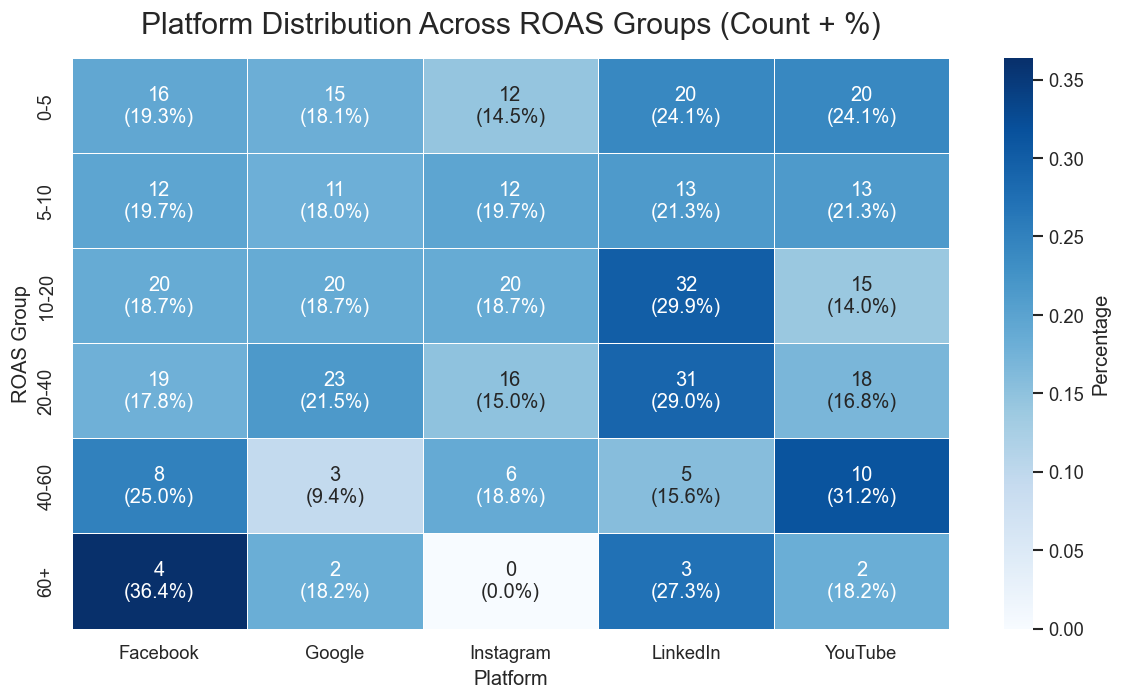


================== Content_Type ==================



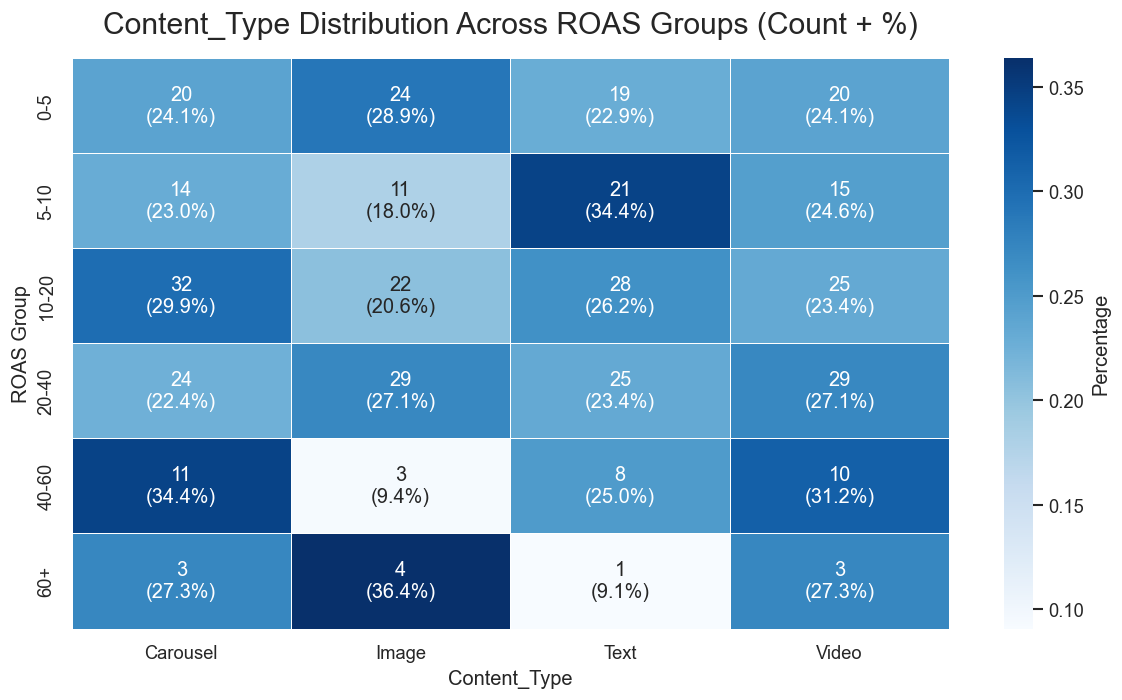


================== Target_Age ==================



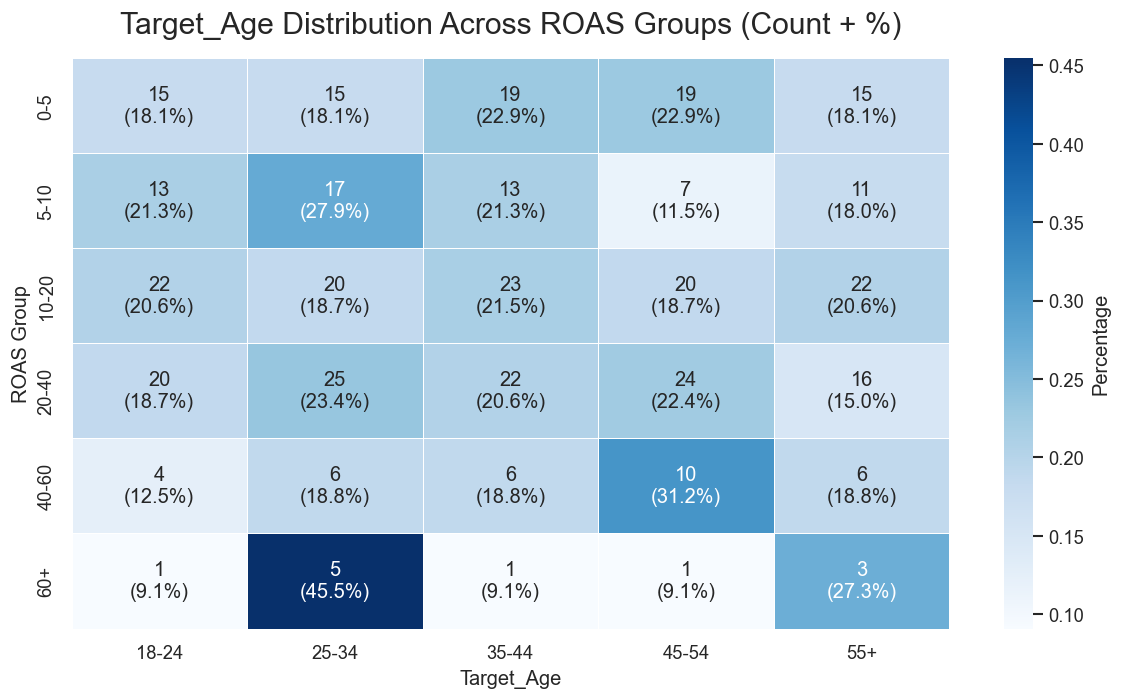


================== Target_Gender ==================



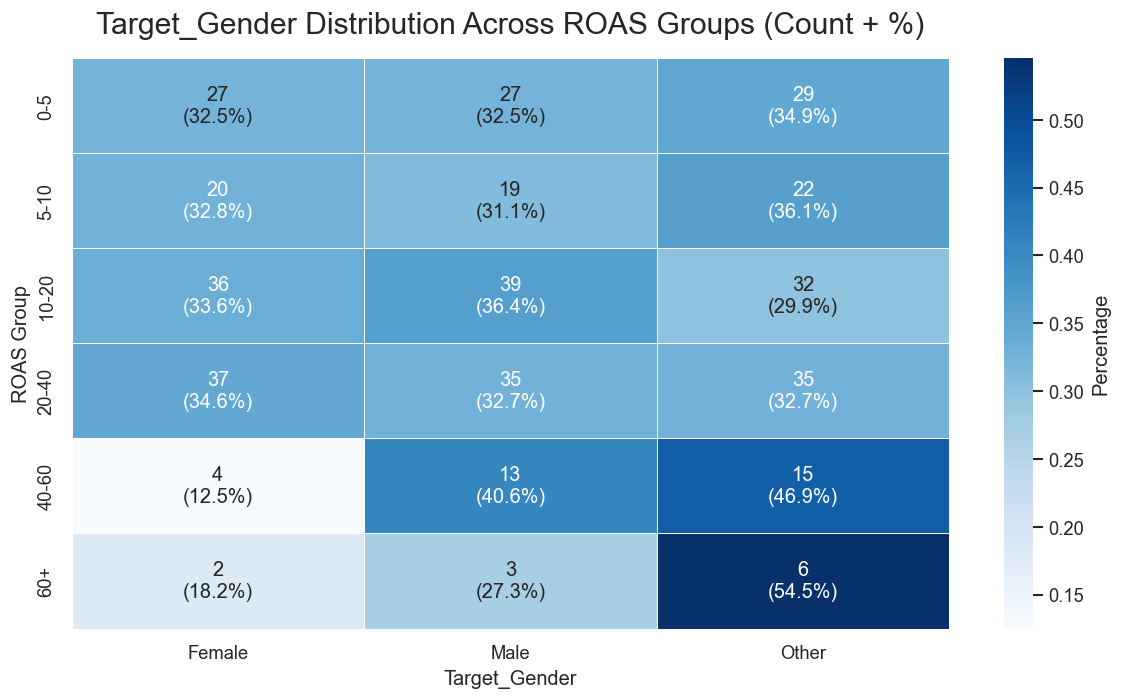


================== Region ==================



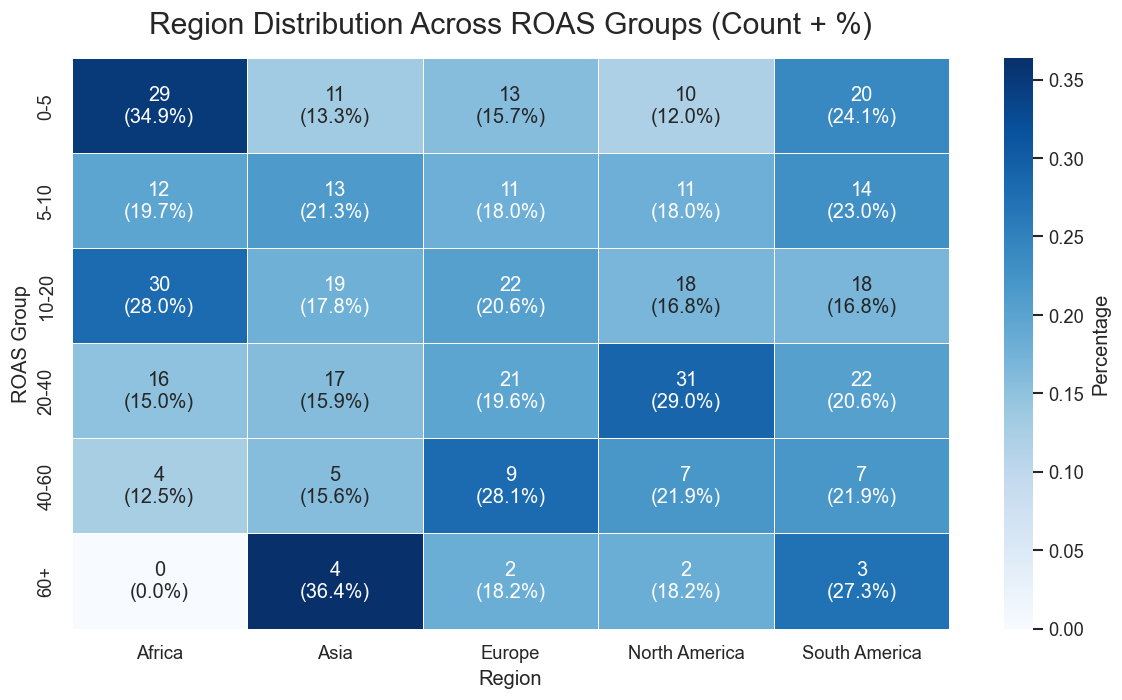

In [80]:
#分布热力矩阵图制作

# 要分析的分类变量
cat_vars = ['Platform', 'Content_Type', 'Target_Age', 'Target_Gender', 'Region']

sns.set(style="white")
plt.rcParams['axes.unicode_minus'] = False



# 1. 计算数量 + 百分比的透视表
def make_pivot_count_percent(df, cat):
    # 计数
    count_tbl = df.groupby(['ROAS_group', cat]).size().unstack().fillna(0)

    # 百分比
    percent_tbl = count_tbl.div(count_tbl.sum(axis=1), axis=0)

    return count_tbl, percent_tbl



# 2. 热力图（数量 + 百分比 同时标注）
def plot_heatmap(count_tbl, percent_tbl, title):

    # 生成注释文本：数量 (百分比)
    annot = count_tbl.astype(int).astype(str) + "\n(" + (percent_tbl*100).round(1).astype(str) + "%)"

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        percent_tbl, 
        annot=annot,
        fmt='',
        cmap="Blues",
        cbar_kws={'label': 'Percentage'},
        linewidths=0.5,
        linecolor="white"
    )

    plt.title(title, fontsize=18, pad=15)
    plt.xlabel(percent_tbl.columns.name)
    plt.ylabel("ROAS Group")
    plt.tight_layout()
    plt.show()



# 主循环：生成热力图
for cat in cat_vars:
    print(f"\n================== {cat} ==================\n")

    count_tbl, percent_tbl = make_pivot_count_percent(low_cpc_df, cat)

    plot_heatmap(
        count_tbl,
        percent_tbl,
        f"{cat} Distribution Across ROAS Groups (Count + %)"
    )


主要观察：
- 样本量分箱后较小，统计特征不够稳定
- 分类变量对 ROAS 的解释力有限

结论：在低 CPC 区间，ROAS 主要受数值变量影响，分类变量对高 ROAS 活动的区分力有限。

### 6.3 低 CPC 区间下：CVR、RPC、CPC、CTR 与 ROAS 的关系

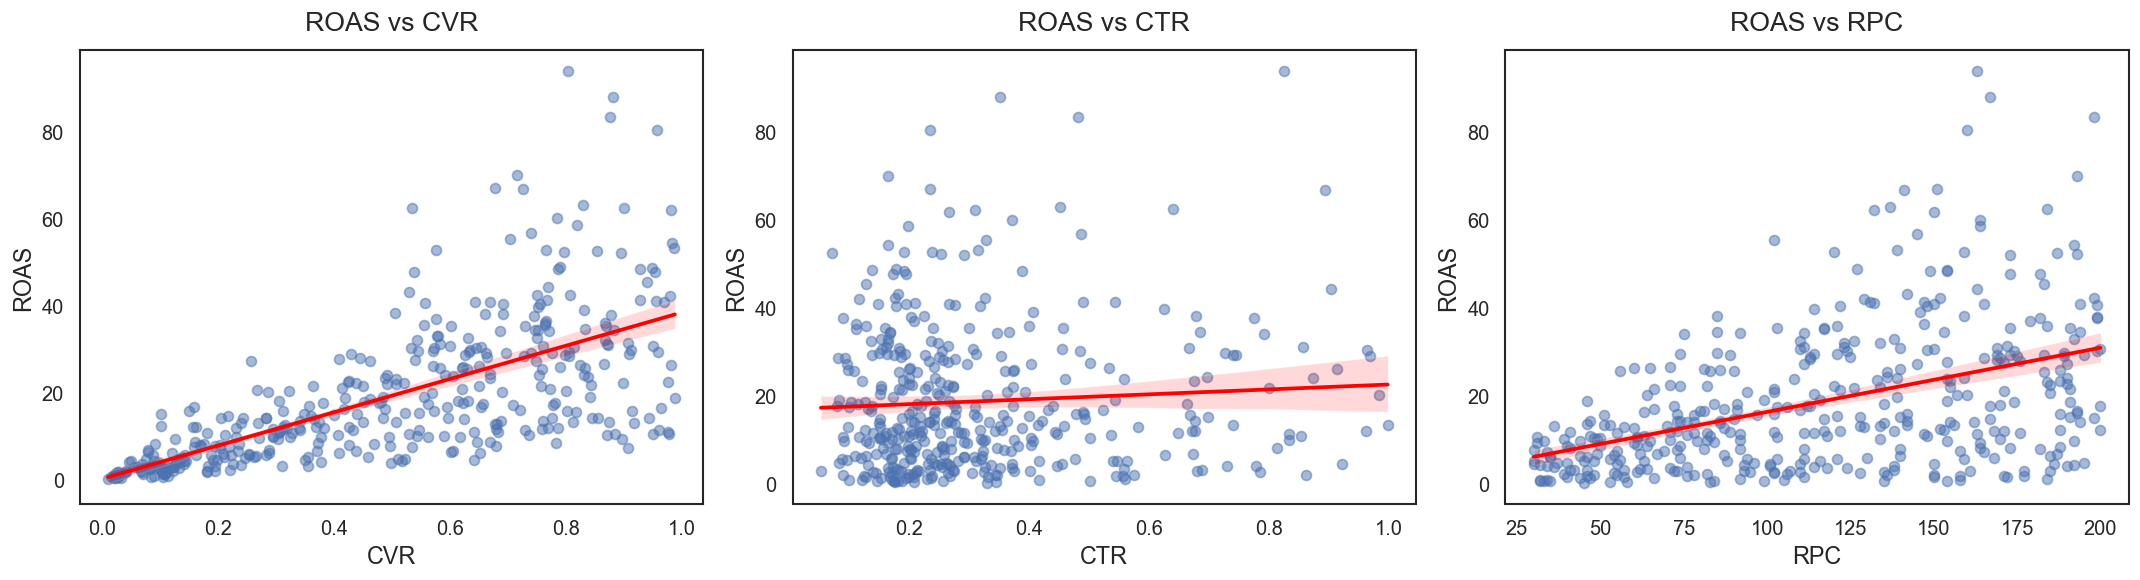

In [82]:
#散点图制作

# 要绘制的变量

vars_to_plot = [
    ("CVR",  "ROAS vs CVR"),
    ("CTR",  "ROAS vs CTR"),
    ("RPC",  "ROAS vs RPC")
]


# 创建 1×3 子图

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (col, title) in zip(axes, vars_to_plot):

    sns.regplot(
        data=low_cpc_df,
        x=col,
        y="ROAS",
        scatter_kws={'alpha':0.5},
        line_kws={'color': 'red'},
        ax=ax
    )

    ax.set_title(title, fontsize=16, pad=12)
    ax.set_xlabel(col, fontsize=14)
    ax.set_ylabel("ROAS", fontsize=14)
    ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()


主要观察：

在 CPC0-5区间，ROAS 主要由 CVR 和 RPC 驱动，而 CTR 对 ROAS 的影响有限，提示优化策略应重点关注提升转化率和转化价值。

### 6.4 低 CPC 区间下的数值变量协同作用——四象限图（RPC × CVR）

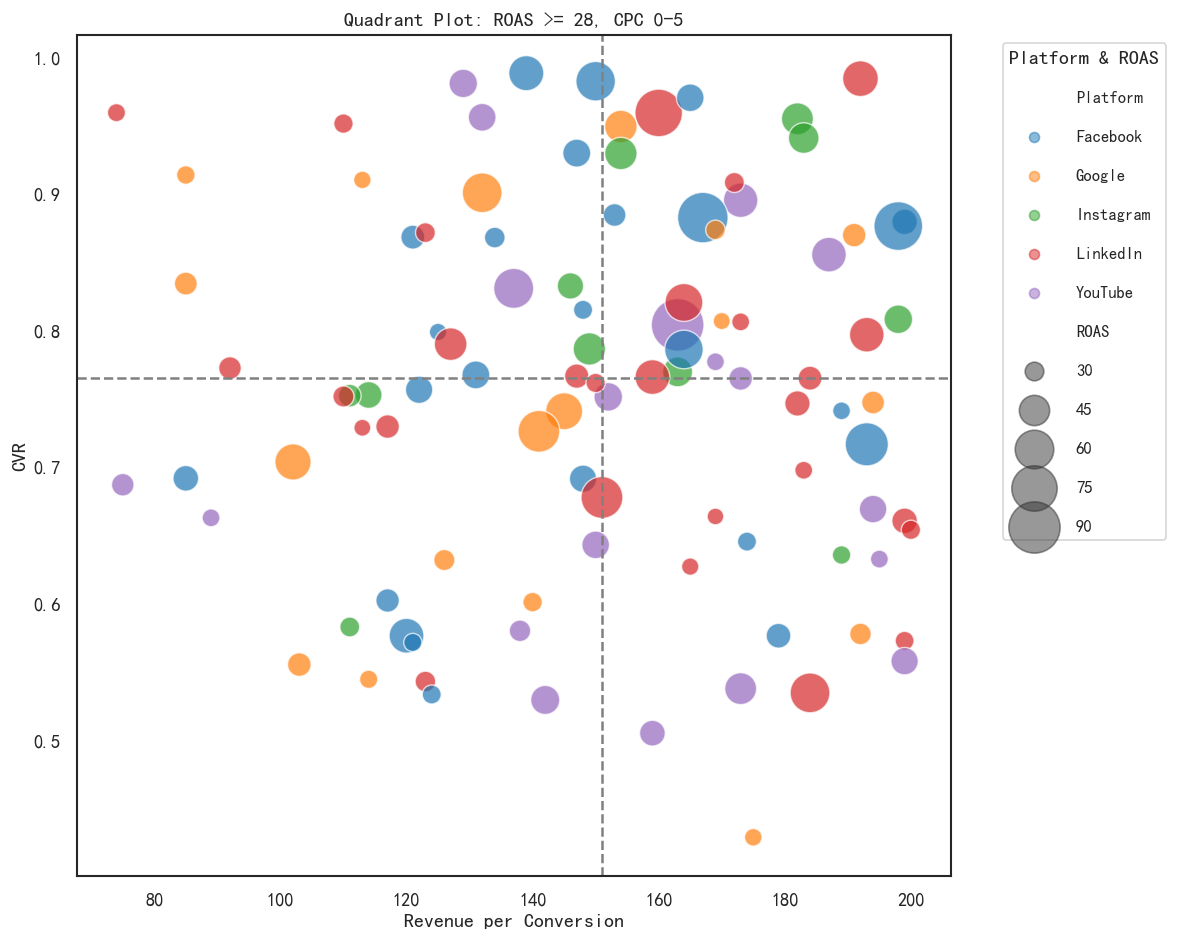

In [50]:
# CPC 0-5 且 ROAS >= 28 的子集
subset_df = df[(df['CPC']>0) & (df['CPC']<=5) & (df['ROAS']>=28)].copy()

# 中位数作为象限分界
rev_median = subset_df['RPC'].median()
cvr_median = subset_df['CVR'].median()

plt.figure(figsize=(10,8))

# 气泡图
scatter = sns.scatterplot(
    data=subset_df,
    x='RPC',
    y='CVR',
    size='ROAS',
    hue='Platform',
    sizes=(100, 1000),
    alpha=0.7,         # 散点透明度
    palette='tab10'
)

# 象限参考线
plt.axvline(x=rev_median, color='grey', linestyle='--')
plt.axhline(y=cvr_median, color='grey', linestyle='--')

# 调整图例
leg = plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    title='Platform & ROAS',
    fontsize=10,
    labelspacing=1.5,   # 图例行间距
    handletextpad=1.5   # 图例圆圈与文字距离
)

# 调整图例中气泡透明度
for handle in leg.legendHandles:
    handle.set_alpha(0.5)

# 坐标轴与标题
plt.title('Quadrant Plot: ROAS >= 28, CPC 0-5')
plt.xlabel('Revenue per Conversion')
plt.ylabel('CVR')

plt.tight_layout()
plt.show()

主要观察：
- 数据点主要集中在右上象限，表明高 ROAS 活动通常同时具有较高 RPC 和 CVR
- 低 RPC、低 CVR 几乎无高 ROAS 样本
- 分类变量在该范围内的影响较弱


结论：低 CPC 区间高 ROAS 活动主要由 CVR 和 RPC共同驱动，优化策略应重点关注提升转化率和单次转化价值，同时控制 CPC 。

# 四 模型

## 1.高ROAS路径挖掘

### 1.1 区间划分：为什么选择 ROAS 10–20 与 20–40？

为了兼顾 策略稳定性 和 高收益机会洞察，将 ROAS 划分为两个业务区间：
- 稳态优化区（10–20）
  - 样本量大（202 条），波动小（标准差约 1.3），指标稳定、可控。
  - 用于提取“日常投放”可复制的稳健规则。
- 高收益探索区（20–40）
  - 样本量充足（136 条），ROAS 中位数 28，多为低 CPC + 高 CVR + 高 RPC组合
  - 用于识别潜在的高回报策略。
  
逻辑：稳态区保证基础收益，高收益区探索潜力路径，兼顾稳定性与策略洞察。

### 1.2决策树：路径挖掘

Decision Tree for ROAS (10,20]:
|--- RPC <= 180.50
|   |--- CVR <= 0.48
|   |   |--- CPC <= 4.39
|   |   |   |--- class: 0
|   |   |--- CPC >  4.39
|   |   |   |--- class: 0
|   |--- CVR >  0.48
|   |   |--- Target_Age_25-34 <= 0.50
|   |   |   |--- class: 1
|   |   |--- Target_Age_25-34 >  0.50
|   |   |   |--- class: 0
|--- RPC >  180.50
|   |--- CPC <= 9.85
|   |   |--- CVR <= 0.38
|   |   |   |--- class: 1
|   |   |--- CVR >  0.38
|   |   |   |--- class: 1
|   |--- CPC >  9.85
|   |   |--- Target_Age_35-44 <= 0.50
|   |   |   |--- class: 0
|   |   |--- Target_Age_35-44 >  0.50
|   |   |   |--- class: 1


Decision Tree for ROAS (20,40]:
|--- CVR <= 0.53
|   |--- CTR <= 0.68
|   |   |--- Target_Age_55+ <= 0.50
|   |   |   |--- class: 0
|   |   |--- Target_Age_55+ >  0.50
|   |   |   |--- class: 0
|   |--- CTR >  0.68
|   |   |--- RPC <= 158.00
|   |   |   |--- class: 0
|   |   |--- RPC >  158.00
|   |   |   |--- class: 1
|--- CVR >  0.53
|   |--- CPC <= 5.29
|   |   |--- RPC <= 109.0

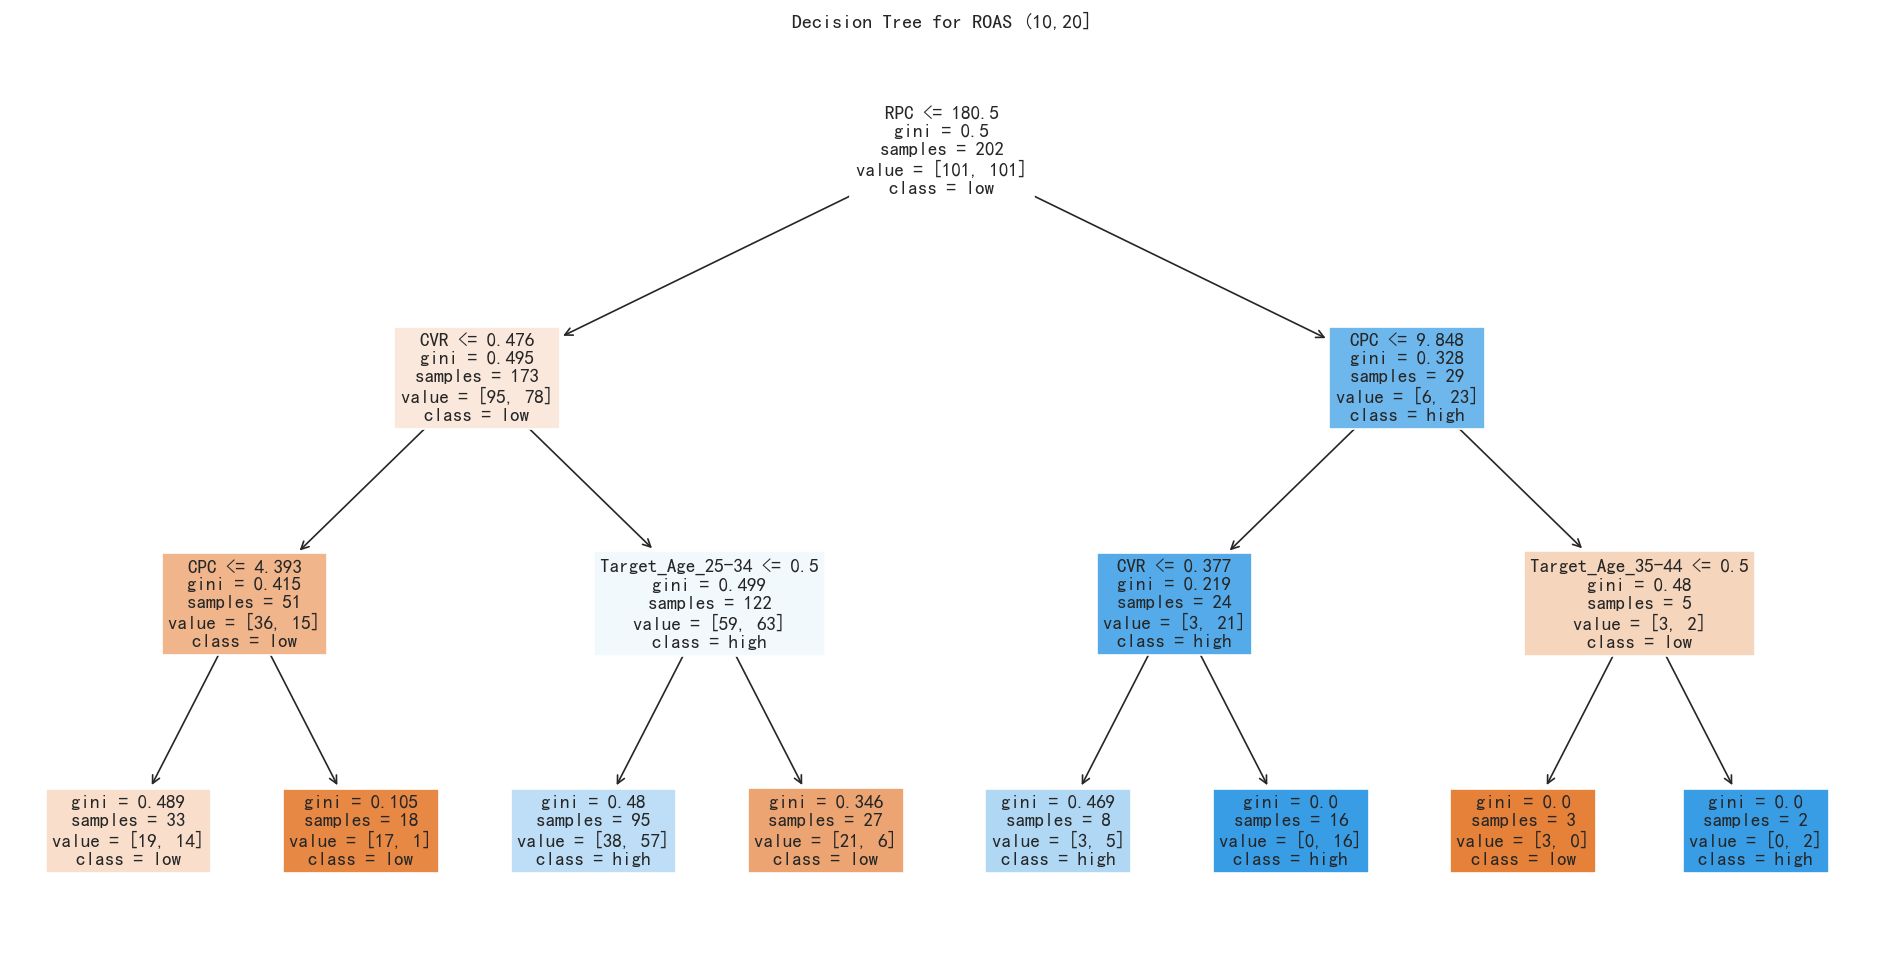

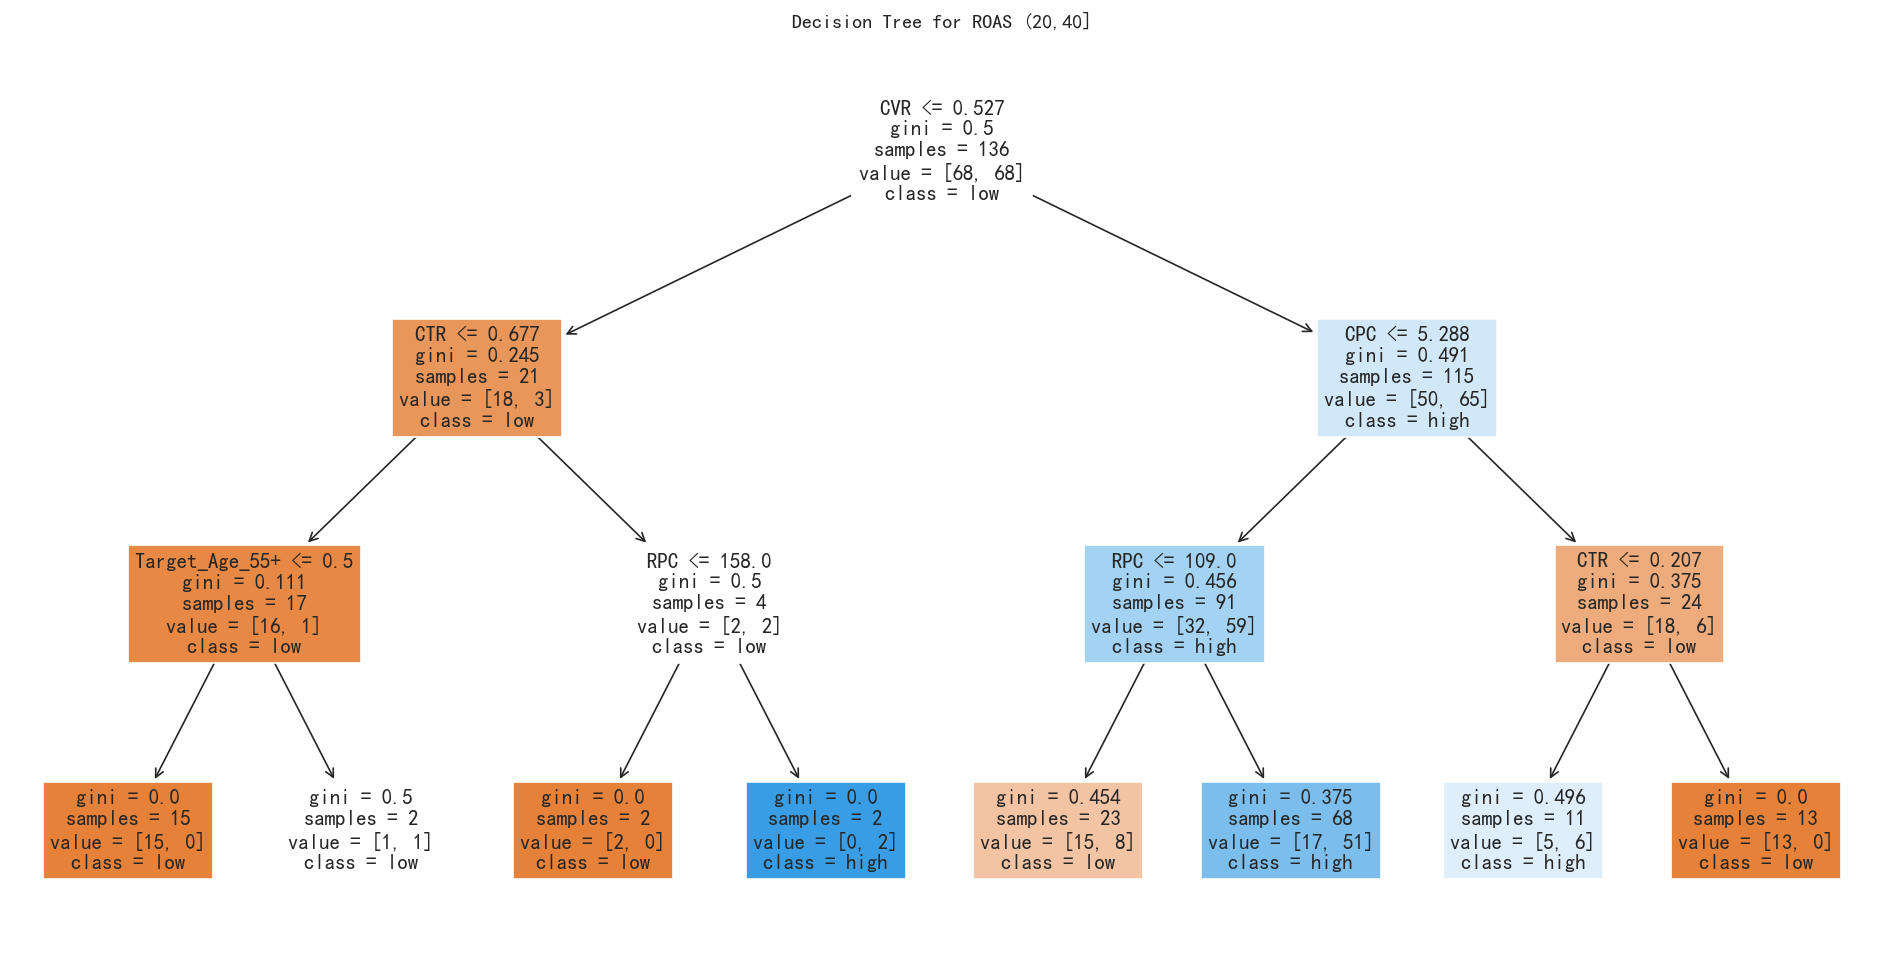

In [55]:
#分别对两个 ROAS 区间构建决策树模型，用于识别能够带来较高 ROAS 的组合特征。
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# 假设你的原始数据是 df
# df 包含 'ROAS'、数值变量和类别变量

# 数值变量
num_vars = ['CVR', 'RPC', 'CTR', 'CPC']
# 类别变量
cat_vars = ['Platform', 'Content_Type', 'Target_Age', 'Target_Gender', 'Region']

# 选择 ROAS 区间的数据
df_10_20 = df[(df['ROAS'] > 10) & (df['ROAS'] <= 20)].copy()
df_20_40 = df[(df['ROAS'] > 20) & (df['ROAS'] <= 40)].copy()

# 定义特征和目标
def prepare_data(df_subset):
    # 目标：高 ROAS，设定阈值为中位数以上为 1，否则 0
    roas_median = df_subset['ROAS'].median()
    df_subset['high_roas'] = (df_subset['ROAS'] > roas_median).astype(int)
    
    X_num = df_subset[num_vars]
    X_cat = df_subset[cat_vars]
    
    # 类别变量 OneHot 编码
    ohe = OneHotEncoder(sparse=False, drop='first')
    X_cat_encoded = ohe.fit_transform(X_cat)
    
    # 合并数值和编码后的类别变量
    import numpy as np
    X = np.hstack([X_num.values, X_cat_encoded])
    y = df_subset['high_roas'].values
    
    return X, y, ohe

# 准备数据
X_10_20, y_10_20, ohe_10_20 = prepare_data(df_10_20)
X_20_40, y_20_40, ohe_20_40 = prepare_data(df_20_40)

# 训练决策树
tree_10_20 = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_10_20.fit(X_10_20, y_10_20)

tree_20_40 = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_20_40.fit(X_20_40, y_20_40)

# 打印文本树
print("Decision Tree for ROAS (10,20]:")
feature_names_10_20 = num_vars + list(ohe_10_20.get_feature_names_out(cat_vars))
print(export_text(tree_10_20, feature_names=feature_names_10_20))

print("\nDecision Tree for ROAS (20,40]:")
feature_names_20_40 = num_vars + list(ohe_20_40.get_feature_names_out(cat_vars))
print(export_text(tree_20_40, feature_names=feature_names_20_40))

# 可视化树
plt.figure(figsize=(20,10))
plot_tree(tree_10_20, feature_names=feature_names_10_20, class_names=['low','high'], filled=True)
plt.title("Decision Tree for ROAS (10,20]")
plt.show()

plt.figure(figsize=(20,10))
plot_tree(tree_20_40, feature_names=feature_names_20_40, class_names=['low','high'], filled=True)
plt.title("Decision Tree for ROAS (20,40]")
plt.show()



##### ROAS (10,20] 区间的 HIGH 关键路径

路径 1:
  - RPC <= 180.50 & CVR > 0.48 & Target_Age_25-34 <= 0.50


路径 2:
  - RPC > 180.50 & CPC <= 9.85
 
路径 3:
  - RPC > 180.50 & CPC > 9.85 & Target_Age_35-44 > 0.50



##### ROAS (20,40] 区间的 HIGH 关键路径

路径 1:
  - CVR <= 0.53 & CTR > 0.68 & RPC > 158.00


路径 2:
  - CVR > 0.53 & CPC <= 5.29 & RPC > 109.00


路径 3:
  - CVR > 0.53 & CPC > 5.29 & CTR <= 0.21

### 1.3路径回测

将所有 6 条候选路径回测全量数据，并以以下标准进行筛选：

- 样本量充足
- ROAS 表现稳定
- 规则是否具备 可执行性（业务可控）

In [92]:
# 数据准备
df1 = df.copy()

# ROAS (10,20] 的路径条件
paths_10_20 = {
    "Path 1": "(RPC <= 180.50) & (CVR > 0.48) & (Target_Age == '25-34')",
    "Path 2": "(RPC > 180.50) & (CPC <= 9.85)",
    "Path 3": "(RPC > 180.50) & (CPC > 9.85) & (Target_Age != '25-34')",
}

# ROAS (20,40] 的路径条件
paths_20_40 = {
    "Path 1": "(CVR > 0.53) & (CPC <= 5.29) & (RPC > 109.00)",
    "Path 2": "(CVR > 0.53) & (CPC > 5.29) & (CTR <= 0.21)",
    "Path 3": "(CVR <= 0.53) & (CTR > 0.68) & (RPC > 158)",
}

def summarize_paths(df_copy, paths):
    summary = []
    for name, condition in paths.items():
        # 使用 query 筛选路径
        df_path = df_copy.query(condition)
        n = len(df_path)
        if n > 0:
            roas_mean = df_path['ROAS'].mean()
            roas_median = df_path['ROAS'].median()
            roas_std = df_path['ROAS'].std()
            cpc_median = df_path['CPC'].median()
            cvr_median = df_path['CVR'].median()
            rpc_median = df_path['RPC'].median()
        else:
            roas_mean = roas_median = roas_std = cpc_median = cvr_median = rpc_median = None

        summary.append({
            'Path': name,
            '样本量': n,
            'ROAS均值': roas_mean,
            'ROAS中位数': roas_median,
            'ROAS标准差': roas_std,
            'CPC中位数': cpc_median,
            'CVR中位数': cvr_median,
            'RPC中位数': rpc_median
        })

    return pd.DataFrame(summary)

# 统计结果
summary_10_20 = summarize_paths(df1, paths_10_20)
summary_20_40 = summarize_paths(df1, paths_20_40)

print("ROAS (10,20] 路径统计:")

display(summary_10_20.style.format(precision=2))

print("\nROAS (20,40] 路径统计:")

display(summary_20_40.style.format(precision=2))

ROAS (10,20] 路径统计:


,Path,样本量,ROAS均值,ROAS中位数,ROAS标准差,CPC中位数,CVR中位数,RPC中位数
0,Path 1,96,17.48,11.39,17.61,5.59,0.69,114.00
1,Path 2,98,22.78,20.56,15.51,4.61,0.57,190.50
2,Path 3,32,5.95,5.88,4.10,17.96,0.55,189.00



ROAS (20,40] 路径统计:


,Path,样本量,ROAS均值,ROAS中位数,ROAS标准差,CPC中位数,CVR中位数,RPC中位数
0,Path 4,117,37.77,34.33,15.32,3.40,0.76,152.00
1,Path 5,209,8.16,6.13,6.90,11.90,0.76,120.00
2,Path 6,7,11.98,11.93,9.29,3.25,0.20,188.00


结果：
- 剔除 4 条路径（样本量不足或波动大或ROAS表现不好）
- 保留两条核心高价值路径：
  
  路径一（稳态区）：RPC > 180.50 且 CPC ≤ 9.85
    - 高转化收入
    - CPC 可控
    - 适合日常投放
  
  路径二（高收益区）：CVR > 0.53 且 CPC ≤ 5.29 且 RPC > 109
    - 高转化效率
    - 低成本（CPC ≤ 5.29）
    - 适合 探索高回报机会 的优化场景


### 1.3路径细化

尝试进一步在：
- 平台 × 内容类型
- 年龄 × 性别 × 地区
等维度中细分规则。

In [60]:
#以路径一为例
path1_df = df[
    (df['RPC'] > 180.50) &
    (df['CPC'] <= 9.85)
]
platform_content_roas_1 = (
    path1_df
    .groupby(['Platform', 'Content_Type'])
    .agg(
        活动数量=('ROAS', 'count'),
        总花费=('Spend', 'sum'),
        总收入=('Revenue', 'sum'),
        ROAS标准差=('ROAS', 'std') 
      
    )
    .assign(
        ROAS=lambda x: x['总收入'] / x['总花费']
    )
    .sort_values('ROAS', ascending=False)
)
platform_content_roas_1.head(10)

活动数量      总花费      总收入    ROAS标准差       ROAS
Platform  Content_Type                                              
LinkedIn  Video            3  14092.5   562619  15.993708  39.923293
YouTube   Image            1   8148.0   238095        NaN  29.221281
Google    Carousel         5  35845.7  1005036   8.801797  28.037840
Facebook  Video            7  35774.5   946986  31.030598  26.470978
Instagram Video            5  25311.3   657886  12.913786  25.991790
          Image            4  24469.0   578792  18.220200  23.654093
YouTube   Carousel         6  32952.1   752313  17.797376  22.830502
LinkedIn  Carousel         9  41226.2   910993  20.245558  22.097428
Instagram Carousel         7  44963.6   983453  10.246401  21.872203
YouTube   Text             3  15040.0   327424  17.760924  21.770213

细分后发现：
  - 样本量极度稀疏（最多只有个位数）
  - 细分类别间 ROAS 波动极大
  
结论：两条核心路径已经是最可执行的规则，进一步细分不可行

因此后续分析重点仍集中在核心数值特征（CPC、CVR、RPC）上，不对分类变量做进一步细化。

## 2.全量数据模型找规律

构建一个“高ROAS概率模型”，识别哪些特征最能推动广告取得高ROAS（>20）

In [83]:

# 1️⃣ 数据准备

# 假设 df 是原始数据，列包括 ROAS, RPC, CPC, CVR, CTR, Platform, Content_Type, Target_Age, Target_Gender, Region 等
df_copy = df.copy()  # 拷贝，避免污染原始数据

# 创建分类标签: ROAS > 20 为高 ROAS
df_copy['ROAS_high'] = (df_copy['ROAS'] > 20).astype(int)  # 1=高ROAS, 0=低ROAS

# 2️⃣ 选择特征
# 数值型特征
num_features = ['RPC', 'CPC', 'CVR', 'CTR', 'Spend']

# 类别型特征
cat_features = ['Platform', 'Content_Type', 'Target_Age', 'Target_Gender', 'Region']

# 3️⃣ 类别变量 One-Hot 编码
encoder = OneHotEncoder(sparse=False, drop='first')  # 避免虚拟变量陷阱
X_cat = encoder.fit_transform(df_copy[cat_features])
X_cat_df = pd.DataFrame(X_cat, columns=encoder.get_feature_names_out(cat_features))

# 4️⃣ 合并数值和编码后的类别变量
X = pd.concat([df_copy[num_features].reset_index(drop=True), X_cat_df], axis=1)
y = df_copy['ROAS_high']

# 5️⃣ 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 6️⃣ 建立随机森林分类模型
rf_clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)

# 7️⃣ 模型预测概率
y_pred_prob = rf_clf.predict_proba(X_test)[:, 1]  # 高 ROAS 的概率

# 8️⃣ 特征重要性
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 9️⃣ 输出
print("=== 特征重要性 ===")
print(feature_importance.head(20))  # 打印前20个最重要特征

# 10️⃣ 平台 × 内容组合分析
platform_content = df_copy.groupby(['Platform', 'Content_Type']).agg(
    Sample_Size=('ROAS_high', 'count'),
    ROAS_high_rate=('ROAS_high', 'mean')
).reset_index()

# 可以排序，筛选样本量>=5
platform_content_filtered = platform_content[platform_content['Sample_Size'] >= 5].sort_values(
    by='ROAS_high_rate', ascending=False
)

print("\n=== 平台×内容组合 ROAS 高比例 ===")
print(platform_content_filtered.head(10))

# -------------------------------
# 年龄 × 性别 × 地区组合分析
# -------------------------------

age_gender_region = df_copy.groupby(['Target_Age', 'Target_Gender', 'Region']).agg(
    Sample_Size=('ROAS_high', 'count'),
    ROAS_high_rate=('ROAS_high', 'mean')
).reset_index()

# 筛选样本量 >= 5
age_gender_region_filtered = age_gender_region[age_gender_region['Sample_Size'] >= 5]

# 按高 ROAS 比例降序排序
age_gender_region_filtered = age_gender_region_filtered.sort_values(by='ROAS_high_rate', ascending=False)

# 输出前20条结果
print("=== 年龄×性别×地区组合 ROAS 高比例 ===")
print(age_gender_region_filtered.head(20))

=== 特征重要性 ===
                 Feature  Importance
2                    CVR    0.296126
1                    CPC    0.252773
0                    RPC    0.165251
4                  Spend    0.107489
3                    CTR    0.095078
17   Target_Gender_Other    0.009310
20  Region_North America    0.005537
9     Content_Type_Image    0.005275
7      Platform_LinkedIn    0.005272
16    Target_Gender_Male    0.005068
8       Platform_YouTube    0.005044
19         Region_Europe    0.004970
10     Content_Type_Text    0.004939
21  Region_South America    0.004838
14      Target_Age_45-54    0.004478
12      Target_Age_25-34    0.004460
15        Target_Age_55+    0.004306
11    Content_Type_Video    0.004258
6     Platform_Instagram    0.004226
13      Target_Age_35-44    0.003810

=== 平台×内容组合 ROAS 高比例 ===
    Platform Content_Type  Sample_Size  ROAS_high_rate
15  LinkedIn        Video           48        0.250000
3   Facebook        Video           46        0.239130
5     Google      

在全量数据上构建分类模型（ROAS > 20）后，虽然识别出变量重要性排名（CVR、CPC、RPC 为主导因素），但：
  - 平台、内容类型、受众维度的重要性普遍 <1%
  - 样本分布高度不均匀，仍无法产出可靠的小类规则
  
洞察：提升 CVR、优化 RPC、控制 CPC 是提升 ROAS 的核心手段；平台×内容组合可辅助识别高 ROAS 活动。

## 3.小结

决策树从两个业务区间抽取 6 条候选路径

回测后仅 2 条路径稳定可靠、可落地执行

- 路径一：RPC > 180.50 & CPC ≤ 9.85（稳态日常策略）
- 路径二：CVR > 0.53 & CPC ≤ 5.29 & RPC > 109（高收益探索策略）

进一步细分因样本不足不可行

全量模型验证：CVR、RPC、CPC 是提升 ROAS 的核心变量

# 五 价值量化

基于上一步得到的两条高 ROAS 路径，使用实际的花费、转化和收益数据，

对以下两个策略场景进行量化模拟,**计算模拟场景下的预期 Revenue 与 ROAS**（仅为业务决策提供参考）：

**场景 1：停止 CPC > 5 的活动，把预算全部分配给 CPC ≤ 5 的活动。**

**场景 2：将当前预算的 50% 投入到两条高 ROAS 核心路径中。**


**模拟依据：**

使用历史转换成本与产出效率（CPC/CPM/ROAS 中位数）

假设预算变动不会改变活动的效率（短期静态假设）

为了避免预算模拟过度乐观，本分析在静态效率假设基础上，额外对 ROAS 施加 20% 的折损系数，以更贴近真实预算扩展时效率的自然衰减。



## 现状

In [86]:
#CPC>5 VS CPC≤5
# 定义分组
groups = np.where(df['CPC'] > 5, 'CPC > 5', 'CPC ≤ 5')

# 聚合统计（使用 groupby(groups)）
summary = df.groupby(groups).agg(
    Count=('CPC', 'count'),
    Spend=('Spend', 'sum'),
    Revenue=('Revenue', 'sum')
)

# 计算占比
summary['Count_Pct'] = summary['Count'] / summary['Count'].sum()
summary['Spend_Pct'] = summary['Spend'] / summary['Spend'].sum()
summary['Revenue_Pct'] = summary['Revenue'] / summary['Revenue'].sum()

# 百分比格式
summary['Count_Pct'] = summary['Count_Pct'].apply(lambda x: f"{x:.1%}")
summary['Spend_Pct'] = summary['Spend_Pct'].apply(lambda x: f"{x:.1%}")
summary['Revenue_Pct'] = summary['Revenue_Pct'].apply(lambda x: f"{x:.1%}")

summary


,Count,Spend,Revenue,Count_Pct,Spend_Pct,Revenue_Pct
CPC > 5,573,3901576.9,25735898,58.8%,67.4%,44.7%
CPC ≤ 5,401,1890827.7,31824898,41.2%,32.6%,55.3%


In [85]:
#两条路径 VS 非路径
# 路径1：中高CVR + 低CPC
path1 = df[
    (df['RPC'] > 180.5) &
    (df['CPC'] <= 9.85)
]

# 路径2：极高CVR + 强变现
path2 = df[
    (df['CVR'] > 0.53) &
    (df['CPC'] <= 5.29)&
    (df['RPC'] >109)  
]


# 非路径（剔除路径1和路径2）
non_path = df.drop(path1.index.union(path2.index))

# 全量
all_data = df

groups = {
    ('路径一', '中高CVR+低CPC'): path1,
    ('路径二', '极高CVR+强变现'): path2,
    ('路径三', '非路径活动'): non_path,
    ('路径四', '全量活动'): all_data
}


summary_table = pd.DataFrame({
    name: {
        '活动数量': len(data),
        'ROAS均值': data['ROAS'].mean(),
        'ROAS中位数': data['ROAS'].median(),
        'ROAS标准差': data['ROAS'].std()
    }
    for name, data in groups.items()
}).T.round(2)

summary_table

,,活动数量,ROAS均值,ROAS中位数,ROAS标准差
路径一,中高CVR+低CPC,98.0,22.78,20.56,15.51
路径二,极高CVR+强变现,117.0,37.77,34.33,15.32
路径三,非路径活动,789.0,7.35,5.25,7.07
路径四,全量活动,974.0,11.55,7.16,13.10


## 场景一：停止 CPC>5，预算转向 CPC≤5

In [67]:
#场景1:停止低效活动,聚焦CPC≤5
# ===== 1. 基础拆分 =====
high_eff = df[df['CPC'] <= 5]   # 高效活动
low_eff  = df[df['CPC'] > 5]    # 低效活动

reallocated_spend = low_eff['Spend'].sum()

assumed_roas = high_eff['ROAS'].median() * 0.8

expected_incremental_revenue = reallocated_spend * assumed_roas

current_total_revenue = df['Revenue'].sum()

new_total_revenue = (
    high_eff['Revenue'].sum() +
    expected_incremental_revenue
)

current_total_spend = df['Spend'].sum()
new_total_spend = high_eff['Spend'].sum() + reallocated_spend

current_roas = current_total_revenue / current_total_spend
expected_roas = new_total_revenue / new_total_spend

roas_lift = (expected_roas - current_roas) / current_roas

print(
    f"【场景1：停止 CPC>5，预算转向 CPC≤5】\n"
    f"可重新分配预算: {reallocated_spend:,.0f}\n"
    f"假设新增预算 ROAS（中位数×80%）: {assumed_roas:.2f}\n"
    f"预期新增收入: {expected_incremental_revenue:,.0f}\n"
    f"当前整体 ROAS: {current_roas:.2f}\n"
    f"预期整体 ROAS: {expected_roas:.2f}\n"
    f"ROAS 提升幅度: {roas_lift:.1%}"
)


【场景1：停止 CPC>5，预算转向 CPC≤5】
可重新分配预算: 3,901,577
假设新增预算 ROAS（中位数×80%）: 11.25
预期新增收入: 43,884,937
当前整体 ROAS: 9.94
预期整体 ROAS: 13.07
ROAS 提升幅度: 31.5%


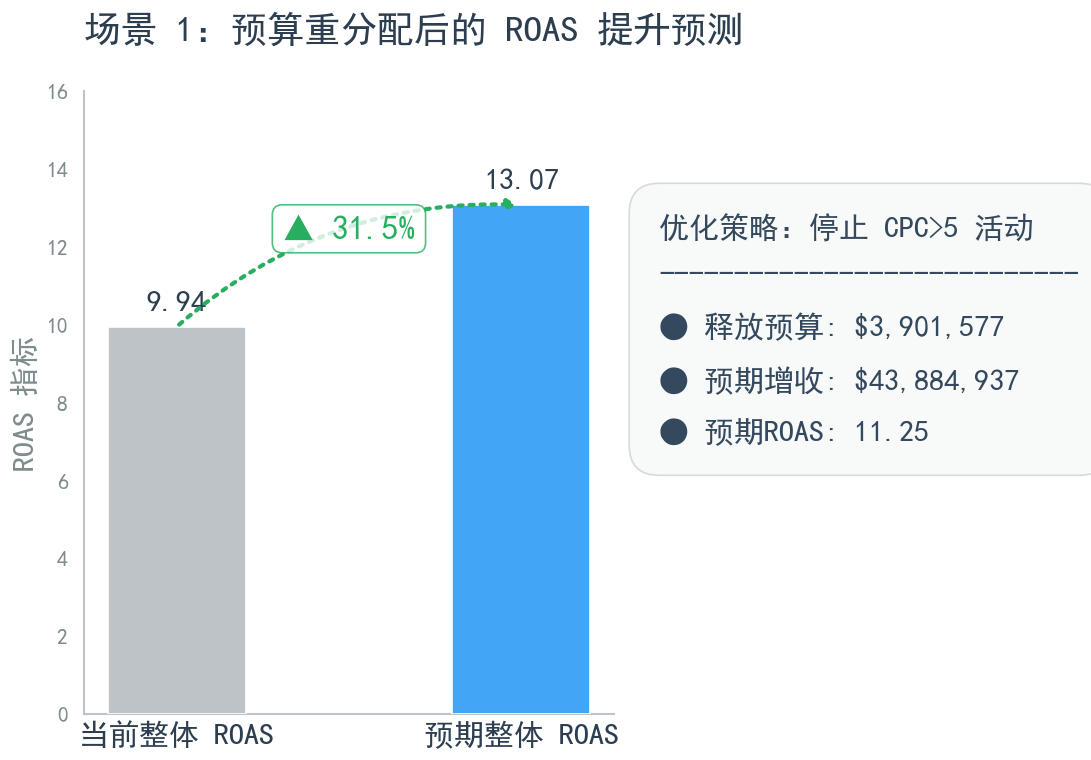

In [88]:
#场景一图表
# 1. 准备数据
metrics = ['当前整体 ROAS', '预期整体 ROAS']
values = [9.94, 13.07]
improvement = "31.5%"

# 详细财务数据
financial_text = (
    f"优化策略：停止 CPC>5 活动\n"
    f"----------------------------\n"
    f"● 释放预算: $3,901,577\n"
    f"● 预期增收: $43,884,937\n"
    f"● 预期ROAS: 11.25"
)

# 设置基础样式
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

# 2. 创建画布 (白色背景)
fig, ax = plt.subplots(figsize=(13, 6.5), facecolor='white')
ax.set_facecolor('white')

# 3. 绘制柱状图
# 当前：灰色，预期：红色
colors = ['#BDC3C7', '#42A5F5']
bars = ax.bar(metrics, values, color=colors, width=0.4, zorder=3)

# 4. 数值标签美化
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.3,
            f'{height:.2f}', 
            ha='center', va='bottom', fontsize=18, 
            fontweight='bold', color='#2C3E50')

# 5. 绘制平滑的提升指示箭头
# 调整箭头位置，使其更美观
ax.annotate('', xy=(1, 13.07), xytext=(0, 9.94),
            arrowprops=dict(arrowstyle='-|>', color='#27AE60', 
                            lw=2.5, ls=':', connectionstyle="arc3,rad=-0.2"))

# 在箭头旁标注提升百分比
ax.text(0.5, 12.2, f'▲ {improvement}', ha='center', 
        fontsize=20, color='#27AE60', fontweight='bold',
       bbox=dict(
        boxstyle="round,pad=0.3",   # 小圆角背景
        fc="white",                 # 背景色
        ec="#27AE60",               # 描边颜色（和箭头一样）
        alpha=0.8                   # 透明度

    ))

# 6. 右侧信息面板美化 (使用文本框)
ax.text(1.4, 7, financial_text, fontsize=18, color='#34495E',
        linespacing=2, bbox=dict(boxstyle="round,pad=1", 
                                 fc="#F8F9F9", ec="#D5DBDB", alpha=1))

# 7. 移除坐标轴边框和刻度，仅保留左侧 Y 轴参考
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#BDC3C7')
ax.spines['bottom'].set_color('#BDC3C7')
ax.tick_params(axis='y', colors='#7F8C8D', labelsize=13)
ax.tick_params(axis='x', colors='#2C3E50', labelsize=18, length=0)

# 8. 标题及布局
plt.title('场景 1：预算重分配后的 ROAS 提升预测', fontsize=22, pad=30, loc='left', fontweight='bold', color='#2C3E50')
ax.set_ylim(0, 16)
ax.set_ylabel('ROAS 指标', color='#7F8C8D', fontsize=18)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.subplots_adjust(right=0.4) # 留

## 场景二：复制“两条路径”（50%预算结构性加码）

In [70]:
#场景二：复制“两条路径”（50%预算结构性加码）
# 路径1：中高收入 + 低CPC
path1 = df[
    (df['RPC'] > 180.5) &
    (df['CPC'] <= 9.85)
]

# 路径2：高CVR + 极低CPC + 中等收入
path2 = df[
    (df['CVR'] > 0.53) &
    (df['CPC'] <= 5.29) &
    (df['RPC'] > 109)
]

# 合并两条路径
path_df = pd.concat([path1, path2], axis=0).drop_duplicates()

# —— 当前整体表现 ——
total_spend = df['Spend'].sum()
total_revenue = df['Revenue'].sum()
current_roas = total_revenue / total_spend

# —— 预算结构（50%复制路径） ——
path_budget = total_spend * 0.5
baseline_budget = total_spend * 0.5

# —— 路径预期ROAS：用中位数 × 保守系数 ——
path_roas_assumed = path_df['ROAS'].median() * 0.8

# —— 新结构收入 ——
new_revenue = (
    baseline_budget * current_roas +  # 原结构维持
    path_budget * path_roas_assumed   # 路径复制
)

expected_roas = new_revenue / total_spend
roas_lift = (expected_roas - current_roas) / current_roas
incremental_revenue = new_revenue - total_revenue

print(
    f"【场景2：复制“两条核心路径”（50%结构性加码）】\n"
    f"路径活动数量: {len(path_df)}\n"
    f"当前整体 ROAS: {current_roas:.2f}\n"
    f"当前整体收入: {total_revenue:,.0f}\n"
    f"路径活动 ROAS（中位数×80%）: {path_roas_assumed:.2f}\n"
    f"———\n"
    f"预期整体 ROAS: {expected_roas:.2f}\n"
    f"ROAS 提升幅度: {roas_lift:.1%}\n"
    f"预期收入: {new_revenue:,.0f}\n"
    f"预期增加收入: {incremental_revenue:,.0f}"
)


【场景2：复制“两条核心路径”（50%结构性加码）】
路径活动数量: 185
当前整体 ROAS: 9.94
当前整体收入: 57,560,796
路径活动 ROAS（中位数×80%）: 22.97
———
预期整体 ROAS: 16.45
ROAS 提升幅度: 65.6%
预期收入: 95,300,372
预期增加收入: 37,739,576


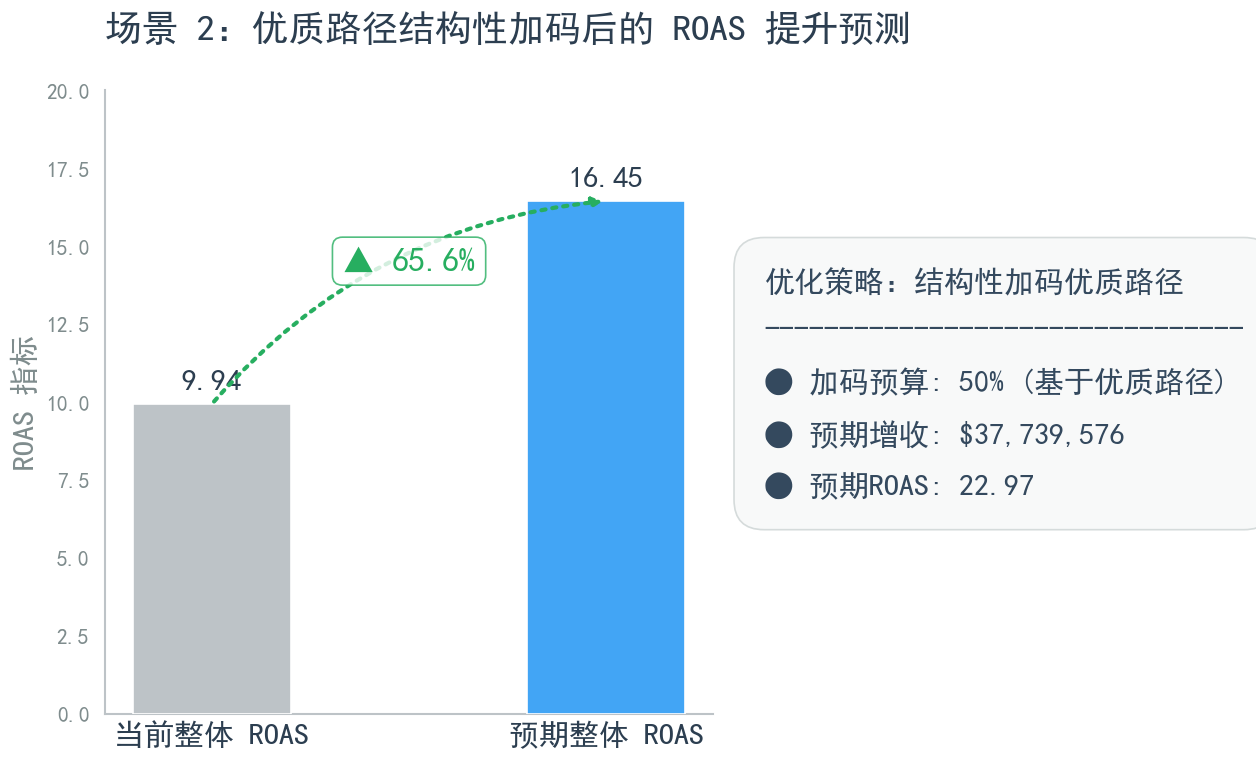

In [89]:
#场景二图表制作


# 1. 准备数据 (场景 2)
metrics_s2 = ['当前整体 ROAS', '预期整体 ROAS']
values_s2 = [9.94, 16.45]  # ROAS 对比
improvement_s2 = "65.6%"

financial_text_s2 = (
    f"优化策略：结构性加码优质路径\n"
    f"--------------------------------\n"
    f"● 加码预算: 50% (基于优质路径)\n"
    f"● 预期增收: $37,739,576\n"
    f"● 预期ROAS: 22.97"
)


# 2. 字体设置
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.family'] = ['SimHei', 'DejaVu Sans']  # 支持 $ 符号
plt.rcParams['axes.unicode_minus'] = False


# 3. 创建画布
fig, ax = plt.subplots(figsize=(13, 6.5), facecolor='white')
ax.set_facecolor('white')


# 4. 绘制柱状图 
colors_s2 = ['#BDC3C7', '#42A5F5']  # 当前=灰色, 预期=蓝色
bars_s2 = ax.bar(metrics_s2, values_s2, color=colors_s2, width=0.4, zorder=3)


# 5. 数值标签
for bar in bars_s2:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2, height + 0.3,
        f'{height:.2f}', 
        ha='center', va='bottom', fontsize=18,
        fontweight='bold', color='#2C3E50'
    )


# 6. 绘制提升箭头
ax.annotate(
    '', xy=(1, 16.45), xytext=(0, 9.94),
    arrowprops=dict(
        arrowstyle='-|>', color='#27AE60',
        lw=2.5, ls=':', connectionstyle="arc3,rad=-0.2"
    )
)

# 提升百分比标签
ax.text(
    0.5, 14.2, f'▲ {improvement_s2}', ha='center',
    fontsize=20, color='#27AE60', fontweight='bold',
    bbox=dict(
        boxstyle="round,pad=0.3",
        fc="white",
        ec="#27AE60",
        alpha=0.8
    )
)


# 7. 右侧信息面板
ax.text(
    1.4, 7, financial_text_s2, fontsize=18, color='#34495E',
    linespacing=2,
    bbox=dict(boxstyle="round,pad=1", fc="#F8F9F9", ec="#D5DBDB", alpha=1)
)


# 8. 坐标轴和刻度样式
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#BDC3C7')
ax.spines['bottom'].set_color('#BDC3C7')

ax.tick_params(axis='y', colors='#7F8C8D', labelsize=13)
ax.tick_params(axis='x', colors='#2C3E50', labelsize=18, length=0)


# 9. 标题及布局
plt.title(
    '场景 2：优质路径结构性加码后的 ROAS 提升预测',
    fontsize=22, pad=30, loc='left', fontweight='bold', color='#2C3E50'
)
ax.set_ylim(0, 20)
ax.set_ylabel('ROAS 指标', color='#7F8C8D', fontsize=18)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # 留出右侧空间
plt.show()

## 小结
- 当前状态分析显示，低 CPC 活动贡献收入较高，且路径一和路径二表现突出
- 优化场景模拟表明：
  - 简单的低效活动剔除即可提升 30% ROAS
  - 聚焦两条核心路径可实现 65% ROAS 提升
- 策略洞察：
  - 日常优化应聚焦低成本高转化活动
  - 核心高 ROAS 路径可作为重点策略组合进行预算倾斜

# 六 关键业务结论

## 1 核心变量识别：明确最值得投入的优化方向

**通过多维度 EDA + 相关性分析 + 模型特征重要性，可以确认：**

 - **CPC（点击成本）是最强杠杆变量**  
   → 成本每下降 1 元，对 ROAS 的正向提升最直接且可控。
   

 - **CVR（转化率）+ RPC（每次转化收入）共同构成“变现强度”**  
   → 决定最终收入天花板，是判断广告是否能扩量的核心维度。
   

 - **CTR / 平台 / 内容的区分度相对有限**  
   → 对 ROAS 的解释度弱于成本与变现指标，不作为主要优化方向。

📌 业务意义：
避免做无效优化，把精力和预算集中在“成本杠杆 + 变现强度”这两件最影响利润的事情上。

## 2 提炼出两条可直接落地的高 ROAS 盈利路径（投放规则化）
**路径一：稳态高变现 —— 日常投放最优解**

**条件：CPC ≤ 9.85 & RPC > 180.50**

**特征：高转化收入，CPC可控，适合日常投放**

**业务动作：**

 - 作为基础盘

 - 保持稳定预算

 - 不刻意压价，但需确保 CPC 在健康区间内  

**路径二：高收益 × 高效率 —— 结构性加码重点**

**条件：CPC ≤ 5.29 & CVR > 0.53 & RPC > 109**

**特征：高转化效率、低成本、适合探索高回报机会的优化场景**

**业务动作：**

 - 出现符合条件的活动 → 快速强力加预算

 - 作为“利润率最高”的抓手

📌 业务意义：

两条路径分别对应 稳定赚钱 与 爆发性增长 的策略，
是可以给投放团队做略化规则参考。

## 3 盈利黄金区间：CPC 0–5 段是利润核心区

 - 高 ROAS 活动大量集中在 **CPC 0–5** 区间

 - CPC 每升高 1 元，ROAS 呈明显非线性下降

 - 该区间是「高效 + 可控成本 + 高密度盈利点」的交集

📌 业务动作：

 - 预算优先倾斜至 CPC ≤5 区间

 - 作为整体盘子的核心利润来源

## 4 量化提升潜力：整体 ROAS 有 30%–60% 的增长空间

基于当前投放结构，通过以下动作可以实现显著提升：

 - 停掉低效活动（CPC 高、ROAS 低）

 - 预算从低效活动回流到盈利路径

 - 重点放大路径二的高效率活动

📌 业务意义：
优化后的 ROAS 存在明显的提升空间，
对投放成本结构和利润率都有直接改善。

# ⭐ 最终总结

本次分析不仅确认了决定 ROAS 的核心变量，也形成了两条可规模化的盈利路径，并给出了清晰的预算重分配策略。整体来看，通过结构化优化，整体 ROAS 存在 30%–60% 的提升空间，是高度可执行且具商业价值的优化方案。